In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys
from importlib import reload
from pathlib import Path
import scanpy as sc
from pylab import rcParams
from matplotlib.patches import Patch
import re
import seaborn as sns
import glob
import math

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import scvelo as scv
scv.logging.print_version()


scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.set_figure_params('scvelo')  # for beautified visualization

%matplotlib inline

Running scvelo 0.2.2 (python 3.8.3) on 2021-04-21 14:00.


In [2]:
###----- Get dir & load / reload packages
try:
    code_dir
except NameError:
    print("Start")
    code_dir = os.getcwd()
    base_dir = code_dir.replace("/plotting_codes","")
    tools_dir = base_dir + "/tools"

    sys.path.insert(1, tools_dir)
    import sc_addons
    import sc_pl_addons
else:
    print("Reload")
    reload(sc_addons)
    reload(sc_pl_addons)

Start


In [3]:
## ----- Setup working dir
sp_name = "0_Acute-Chronic"
analysis_name = ["0", "resampled"] 

wk_dir = base_dir + "/9_Figures/%s/%s_%s"%(sp_name, analysis_name[0], analysis_name[1])
Path(wk_dir).mkdir(parents=True, exist_ok=True)
os.chdir(wk_dir)

print(sp_name)

0_Acute-Chronic


In [4]:
###----- old - new cluster names
order_file ='%s/%s/2_scVelo'%(base_dir, sp_name) + '/%s_scVelo_out_%sNoDyn/pt_ordered_cluster_avg.csv'%(analysis_name[0], analysis_name[1])
order_df = pd.read_csv(order_file)
louvain_new_ordered = order_df['louvain_new_label'].tolist()
louvain_old_ordered = order_df['louvain'].tolist()
order_file

'/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampledNoDyn/pt_ordered_cluster_avg.csv'

In [5]:
adata_h5ad = '%s/%s/1_Scanpy'%(base_dir, sp_name) + '/%s_Scanpy_out_%s/%s_paga.h5ad'%(analysis_name[0], analysis_name[1], sp_name)
adata = sc.read_h5ad(adata_h5ad)

adata.obs["louvain_celltype"] = ["%s_%s"%(x,y) for index, (x,y) in enumerate(zip(adata.obs['louvain'], adata.obs['cell_type']))]

#--- Match old & new louvain levels
adata.obs['louvain_old'] = adata.obs['louvain']
adata.uns['louvain_old_colors'] = adata.uns['louvain_colors']
adata.obs['louvain'] = [ louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in adata.obs['louvain'] ]
category_order = order_df.sort_values('louvain')['louvain_new_label'].tolist()
adata.obs['louvain'] = pd.Categorical(adata.obs['louvain'].tolist(), categories=category_order) # The key is to set categories according to original order...

adata.obs['Infection type'] = [ 'Armstrong' if 'A' in x else 'Clone13' if 'C' in x else 'Naive' for x in adata.obs['cell_type']]
adata.obs['cell_id'] = adata.obs.index.tolist()

In [6]:
###----- Create object with louvain clusters ranekd by new order
old_louvain_order = adata.obs['louvain'].cat.categories.tolist()
old_louvain_colors = adata.uns['louvain_colors']
new_louvain_colors = [old_louvain_colors[old_louvain_order.index(x)] for x in louvain_new_ordered]

adata_neworder = adata.copy()
adata_neworder.obs['louvain'] = pd.Categorical(adata.obs['louvain'].tolist(), categories=louvain_new_ordered)
adata_neworder.uns['louvain_colors'] = new_louvain_colors

adata_neworder.obs['louvain_celltype_general'] = ["%s_%s"%(x,y[0]) for index, (x,y) in enumerate(zip(adata_neworder.obs['louvain'], adata_neworder.obs['cell_type']))]
louvain_newordered_celltype_general = [x+"_"+y for x in louvain_new_ordered for y in ['C', 'A', 'N']]
adata_neworder.obs['louvain_celltype_general'] = pd.Categorical(adata_neworder.obs['louvain_celltype_general'].tolist(), categories=louvain_newordered_celltype_general)

In [7]:
paga_xmax, paga_ymax = np.amax(adata.obsm['X_draw_graph_fa'], axis=0)
paga_xmin, paga_ymin = np.amin(adata.obsm['X_draw_graph_fa'], axis=0)
paga_dx, paga_dy = paga_xmax - paga_xmin, paga_ymax - paga_ymin
paga_xmax, paga_xmin = paga_xmax + paga_dx*0.1, paga_xmin - paga_dx*0.1
paga_ymax, paga_ymin = paga_ymax + paga_dy*0.1, paga_ymin - paga_dy*0.1

# 1. Scatterplots

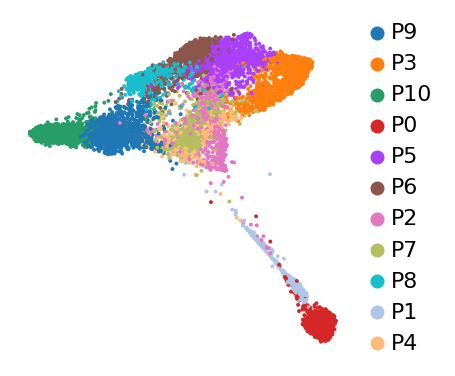

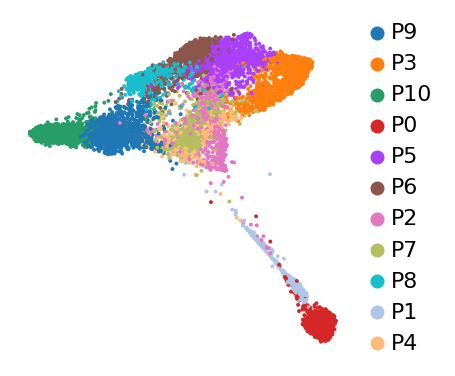

In [230]:
### New louvain cluster numeric order plot
save_name = '_louvain_new_scatter_with_leg'

### Plot
rcParams['figure.figsize'] = 3, 3

sc.pl.draw_graph(adata, color=['louvain'], frameon=False, save = save_name + '.png', title='')
sc.pl.draw_graph(adata, color=['louvain'], frameon=False, save = save_name + '.pdf', title='')

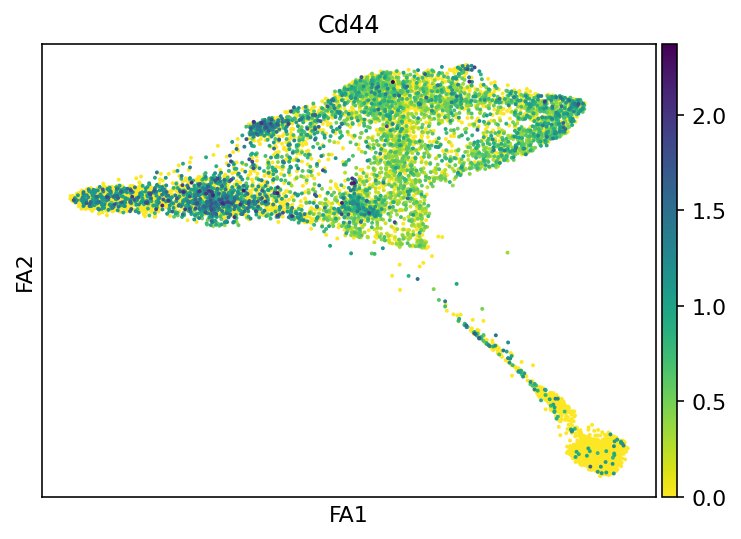

In [9]:
sc.pl.draw_graph(adata, color=['Cd44'], cmap = 'viridis_r')

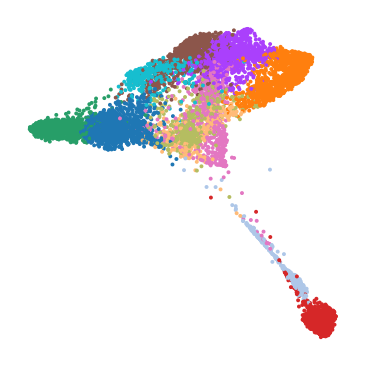

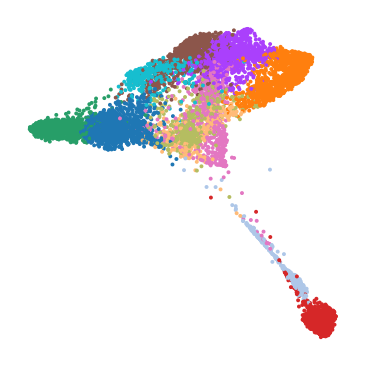

In [233]:
### New louvain cluster numeric order plot
save_name = '_louvain_new_scatter'

### Plot
rcParams['figure.figsize'] = 3, 3

sc.pl.draw_graph(adata, color=['louvain'], frameon=False, legend_loc=None, save = save_name + '.png', title='')
sc.pl.draw_graph(adata, color=['louvain'], frameon=False, legend_loc=None, save = save_name + '.pdf', title='')

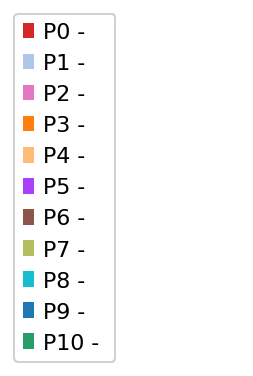

In [118]:
### New louvain cluster numeric order legend
save_name = 'louvain_new_scatter_leg'

### Plot
fig, ax=plt.subplots(figsize=(2,3))

phenotype_labels = ["" for x in louvain_new_ordered]

cpatch_elements = []
for i in range(0,len(louvain_new_ordered)):
    cpatch_elements.append(Patch(facecolor=adata.uns['louvain_colors'][louvain_old_ordered[i]], label="%s - %s" %(louvain_new_ordered[i], phenotype_labels[i])))

ax.add_artist(ax.legend(handles=cpatch_elements, loc=[0,0]))
ax.axis('off')
plt.show()
fig.savefig("figures/%s.png"%save_name)
fig.savefig("figures/%s.pdf"%save_name)
plt.close()

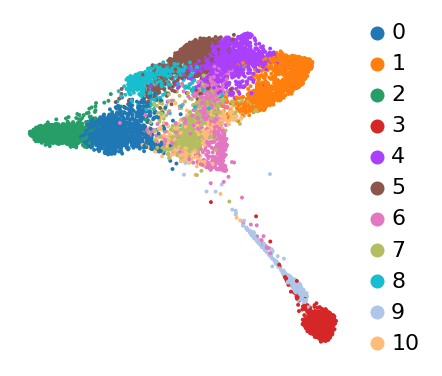

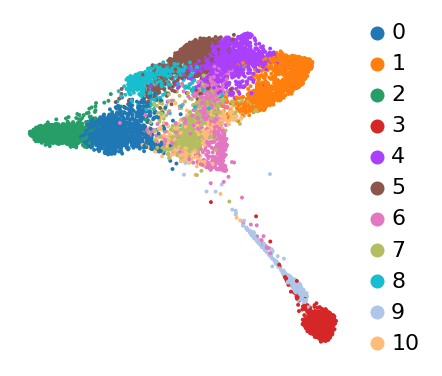

In [232]:
### Original louvain cluster numeric order
save_name = '_louvain_old_scatter'

### Plot
rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['louvain_old'], frameon=False, save=save_name + '.png', title='')
sc.pl.draw_graph(adata, color=['louvain_old'], frameon=False, save=save_name + '.pdf', title='')

In [31]:
import math

In [61]:
adata_arm = adata[adata.obs['Infection type'] == "Armstrong"]
adata_cl13 = adata[adata.obs['Infection type'] == "Clone13"]

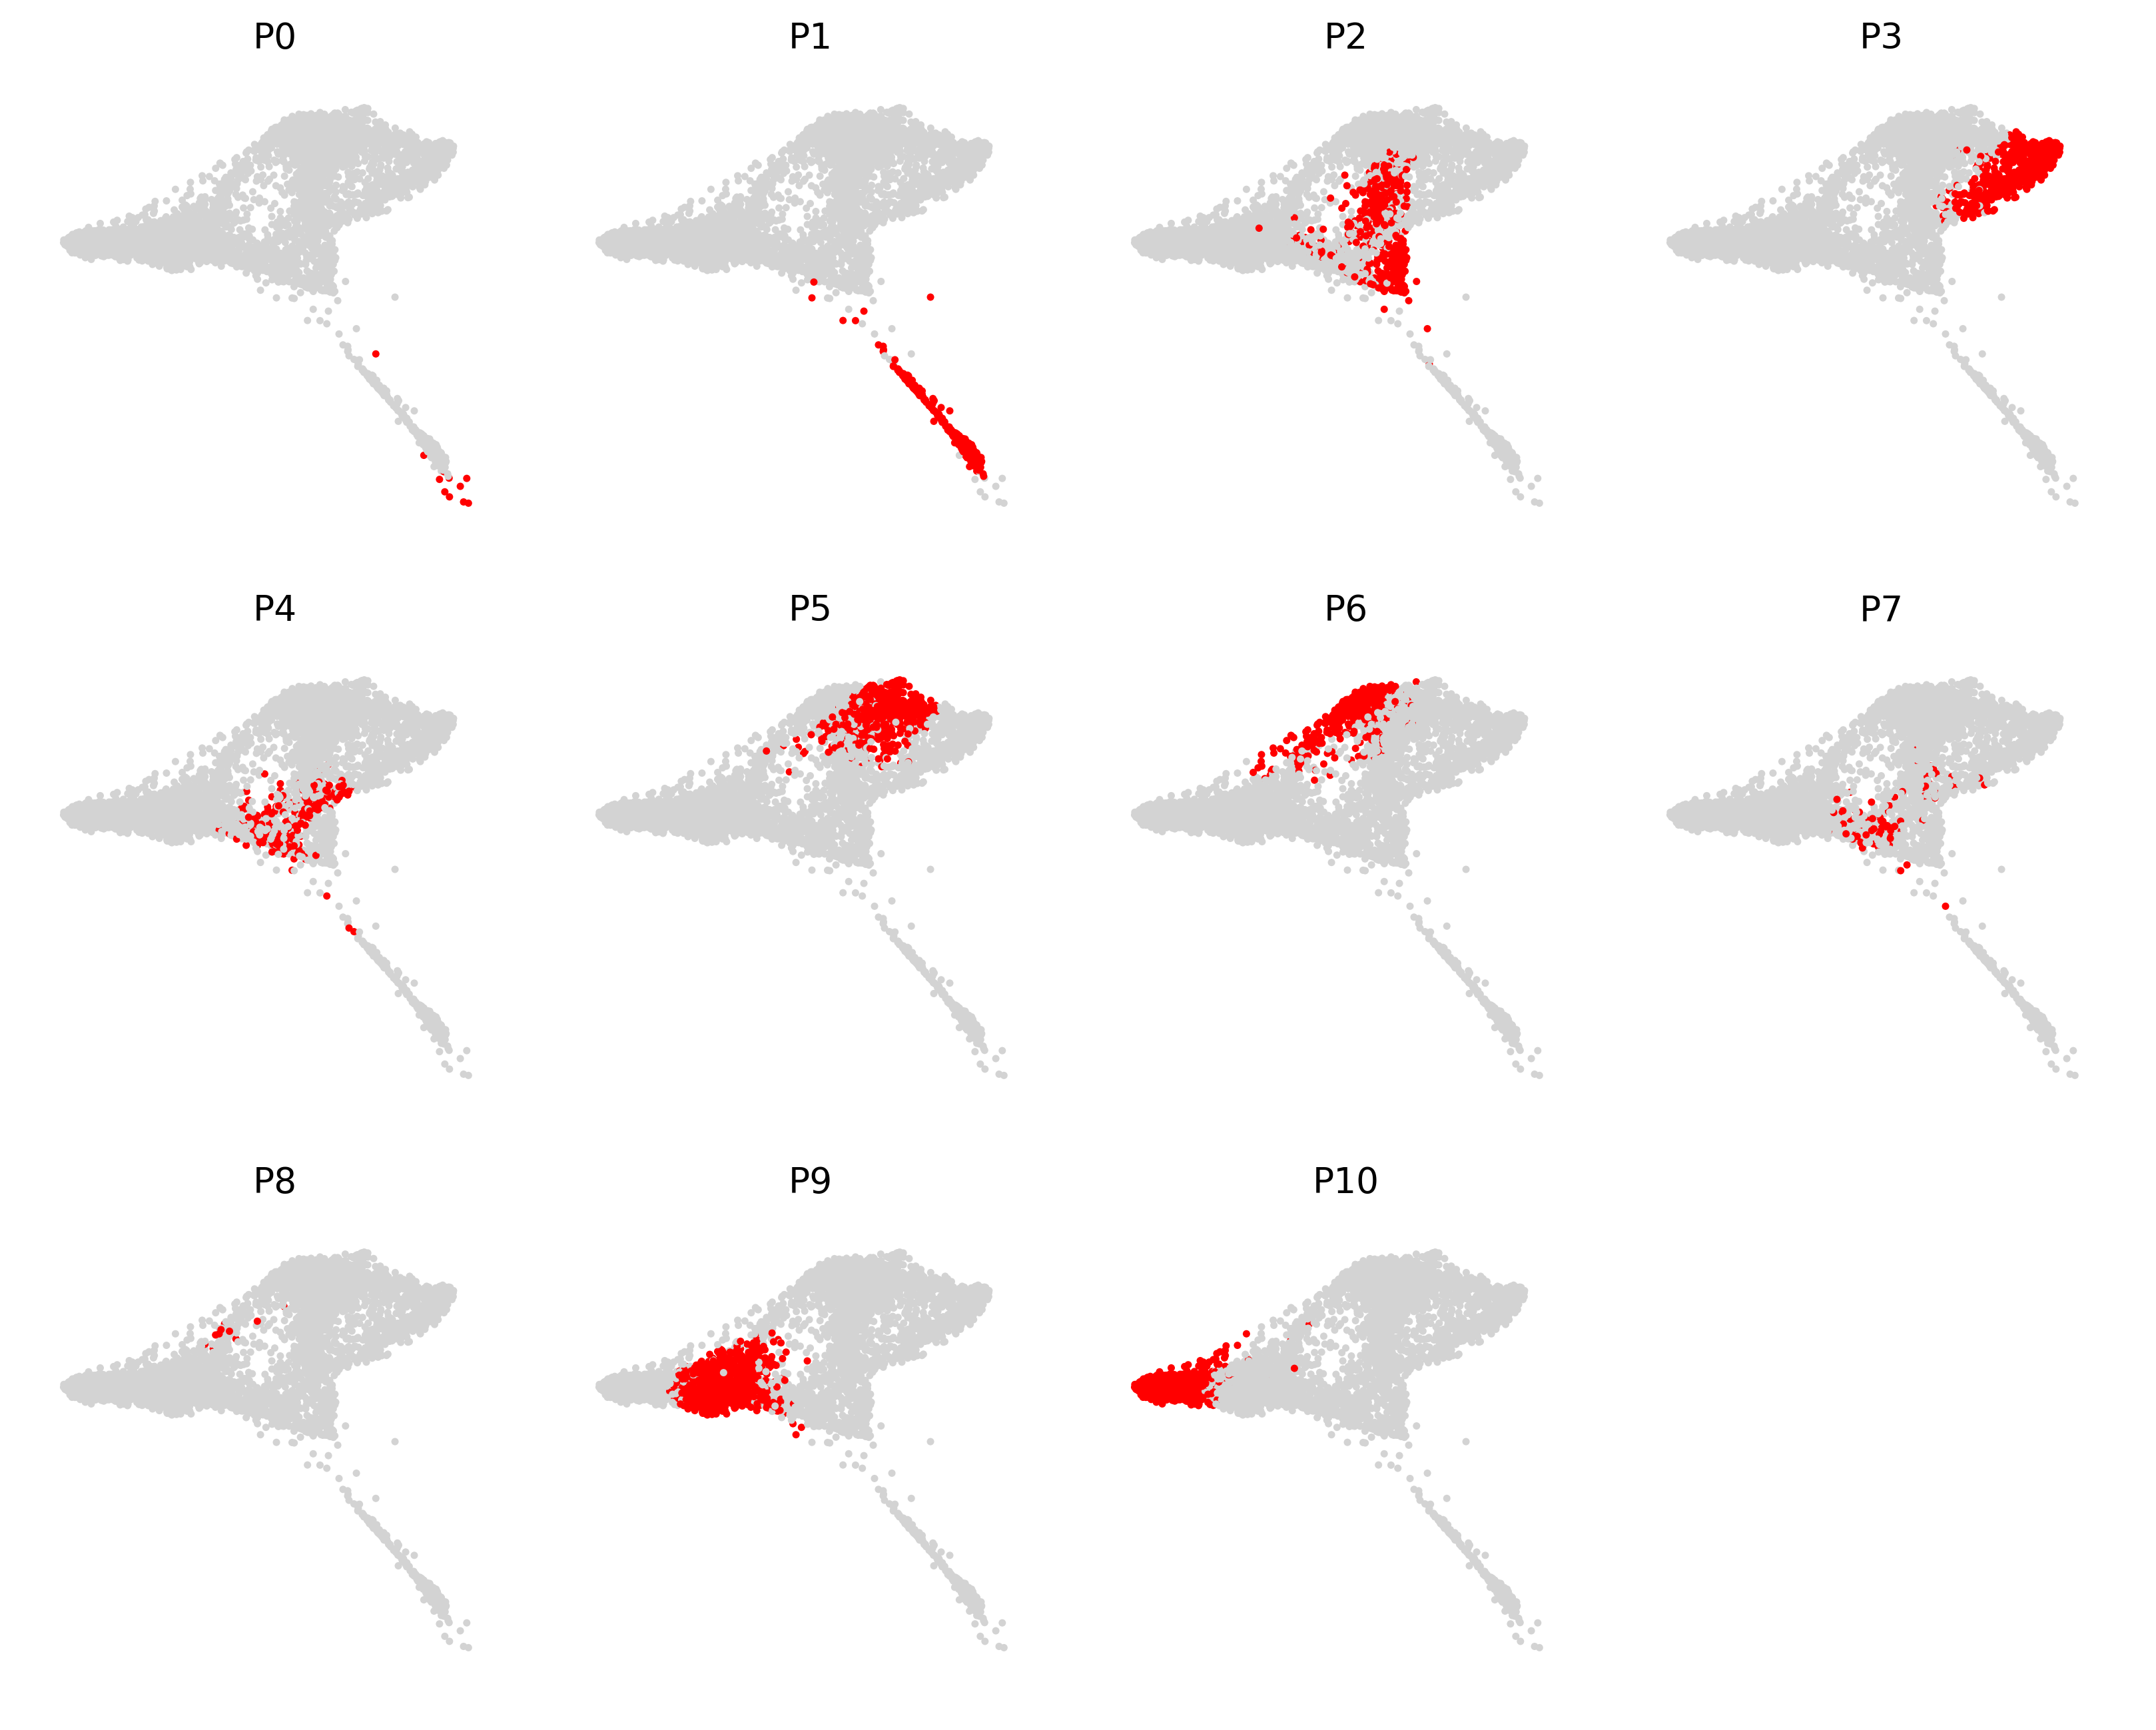

In [80]:
### For Arm / Cl13, plot each cluster
save_name = 'Arm_cluster_highlight'
adata_use = adata_arm

### Plot
fig, axes = plt.subplots(ncols=4, nrows=3, sharey=False, figsize=(10,8), constrained_layout = True, dpi=160)
for i in range(0, len(louvain_new_ordered)):
    i_louvain = louvain_new_ordered[i]
    i_col = i % 4
    i_row = math.floor(i/4)
    ax_i = axes[i_row][i_col]
    ax_i.set_xlim(paga_xmin, paga_xmax)
    ax_i.set_ylim(paga_ymin, paga_ymax)

    adata_use.obs['highlight'] = pd.Categorical(["yes" if x == i_louvain else "no" for x in adata_use.obs['louvain']], dtype="category", categories=["yes", "no"])
    sc.pl.draw_graph(adata_use, color=['highlight'], frameon=False, palette=['red','lightgray'], title=i_louvain, 
                     legend_loc=None, show=False, ax=ax_i)
    
axes[-1][-1].axis('off')
plt.show()
fig.savefig(save_name + '.png')

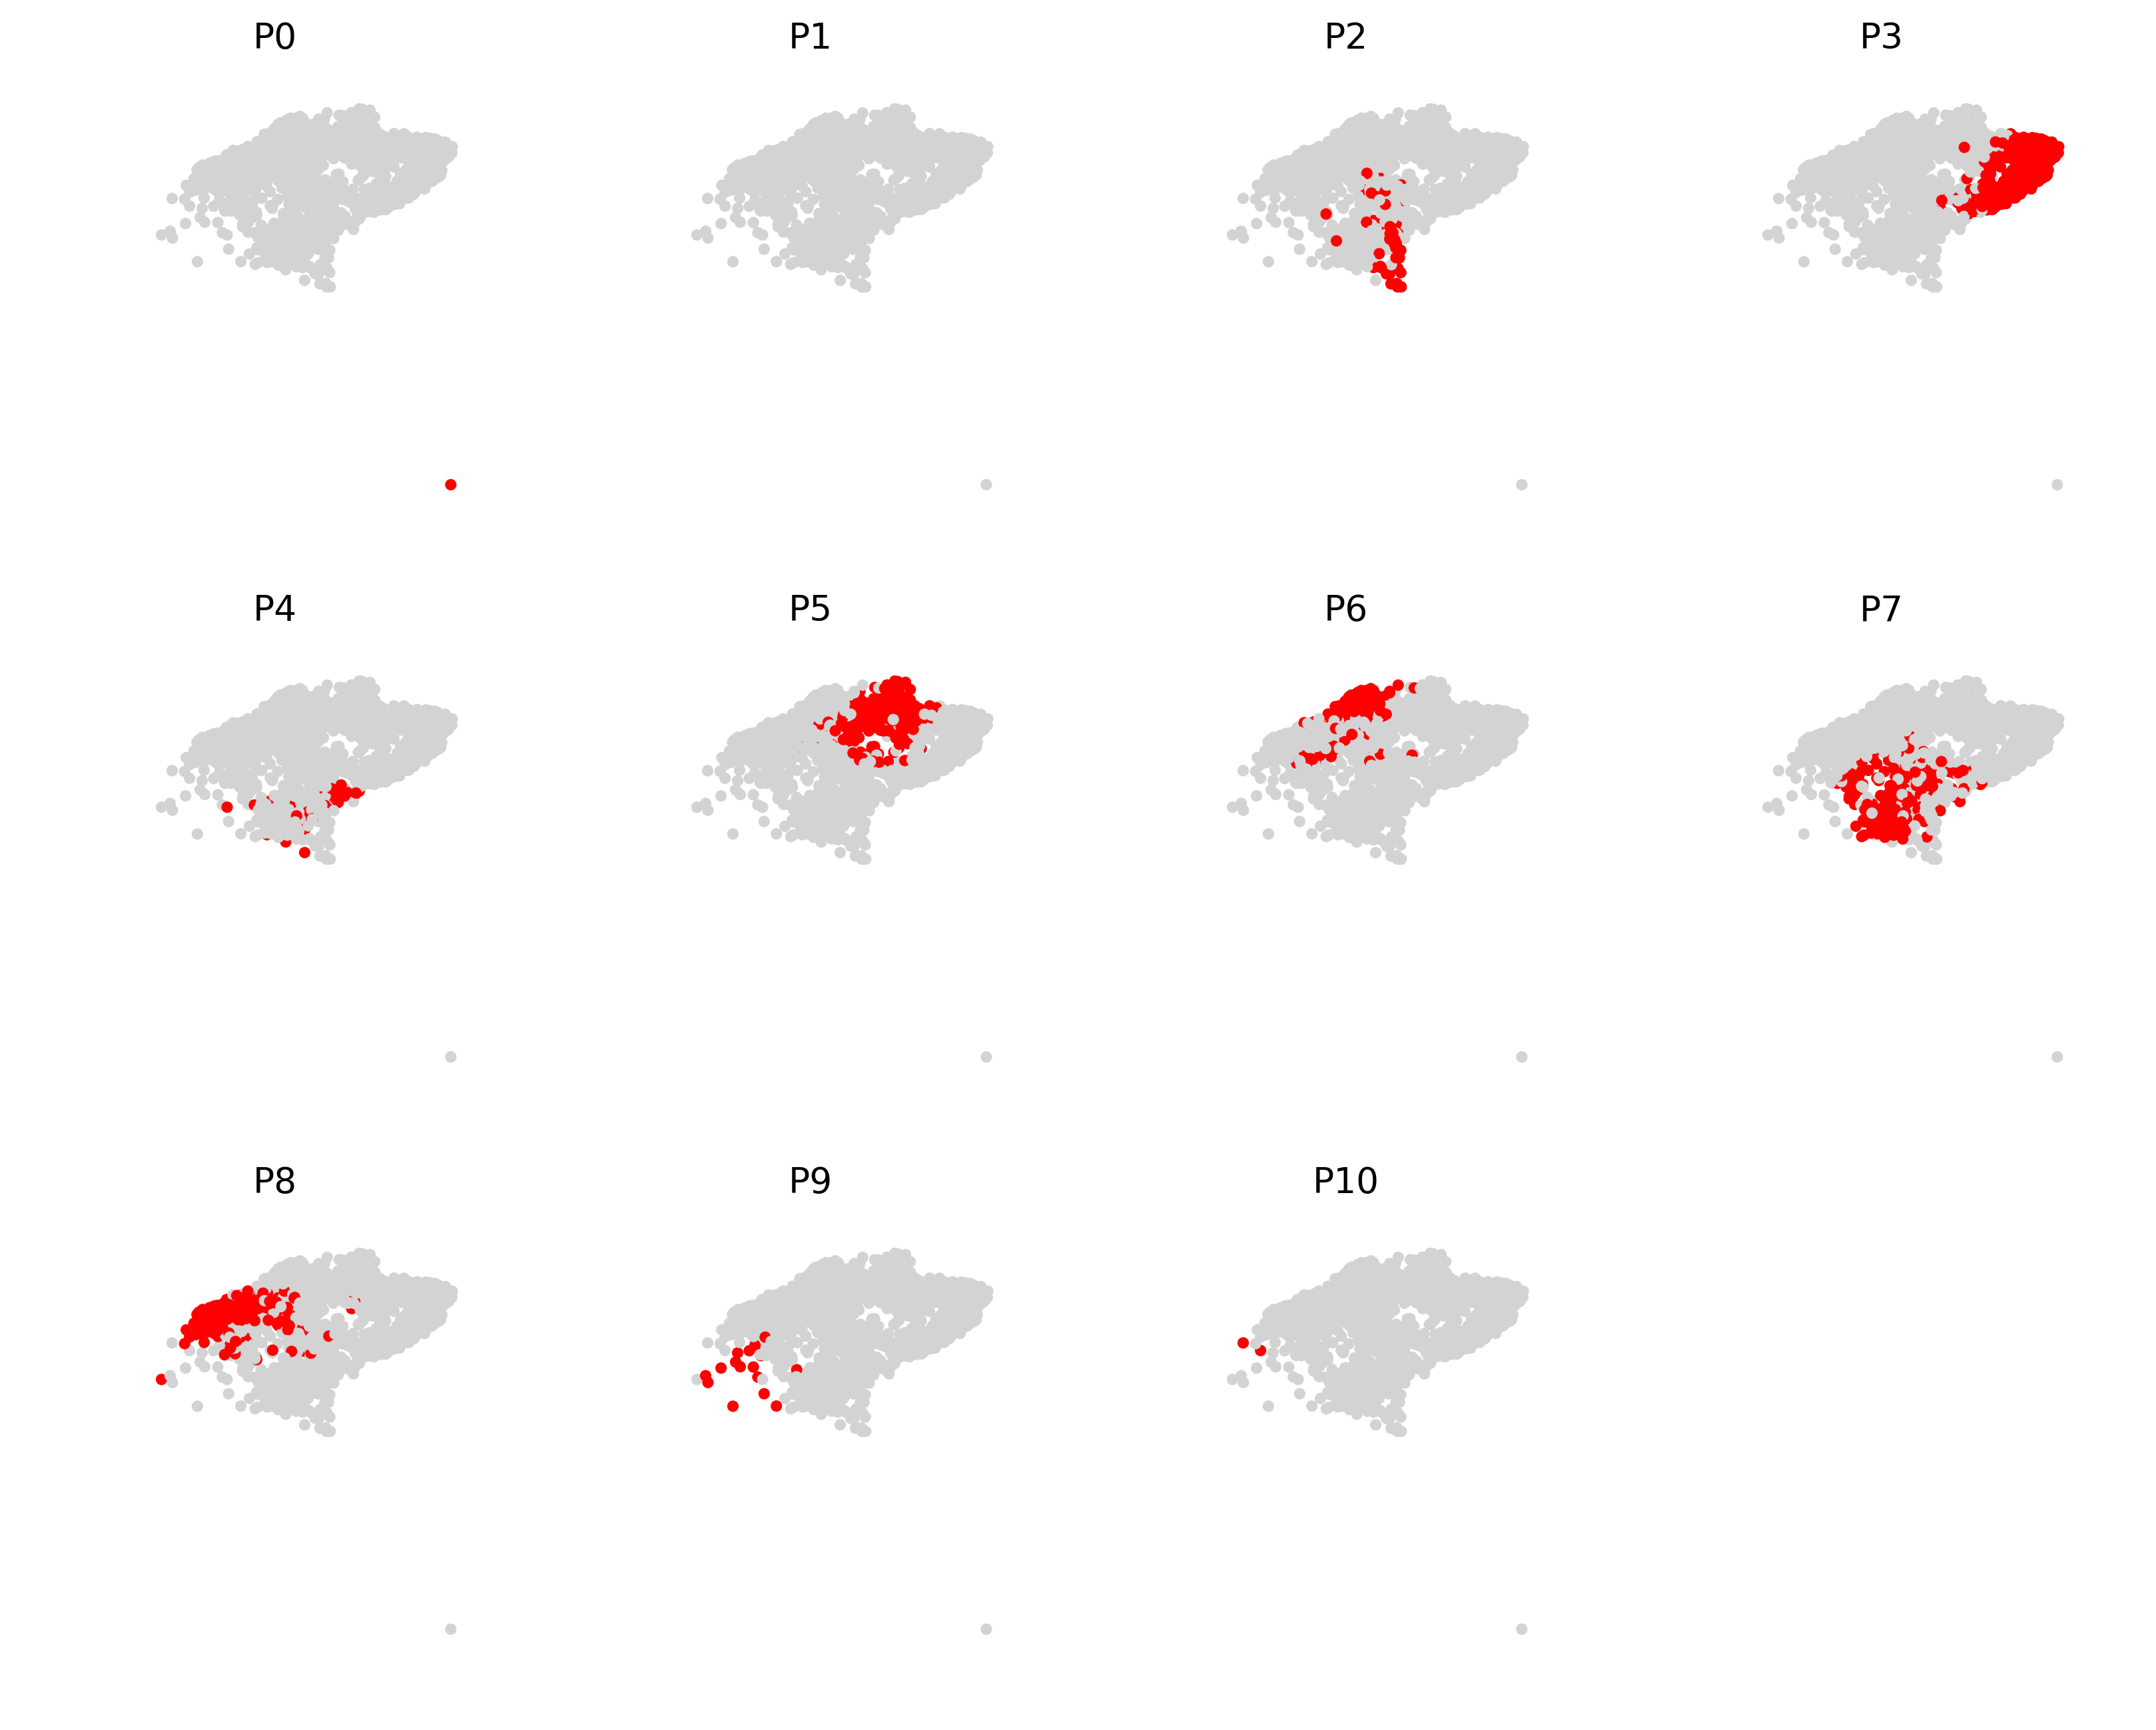

In [81]:
### For Arm / Cl13, plot each cluster
save_name = 'Cl13_cluster_highlight'
adata_use = adata_cl13

### Plot
fig, axes = plt.subplots(ncols=4, nrows=3, sharey=False, figsize=(10,8), constrained_layout = True, dpi=160)
for i in range(0, len(louvain_new_ordered)):
    i_louvain = louvain_new_ordered[i]
    i_col = i % 4
    i_row = math.floor(i/4)
    ax_i = axes[i_row][i_col]
    ax_i.set_xlim(paga_xmin, paga_xmax)
    ax_i.set_ylim(paga_ymin, paga_ymax)

    adata_use.obs['highlight'] = pd.Categorical(["yes" if x == i_louvain else "no" for x in adata_use.obs['louvain']], dtype="category", categories=["yes", "no"])
    sc.pl.draw_graph(adata_use, color=['highlight'], frameon=False, palette=['red','lightgray'], title=i_louvain, 
                     legend_loc=None, show=False, ax=ax_i)
    
axes[-1][-1].axis('off')
plt.show()
fig.savefig(save_name + '.png')

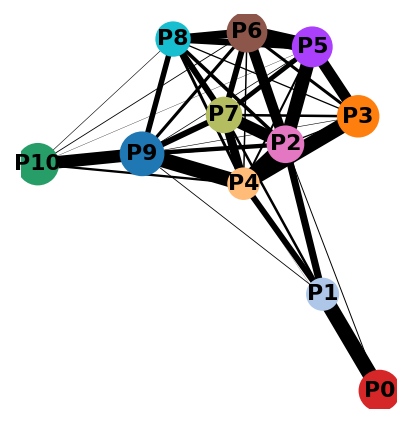

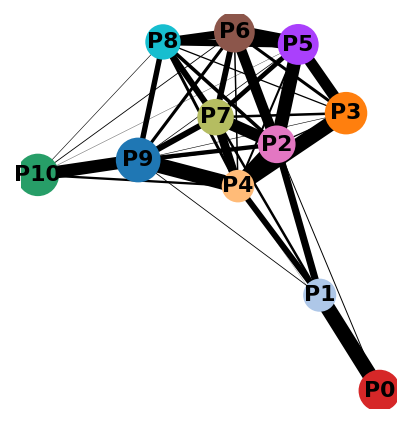

In [240]:
### New louvain cluster numeric order - Node plot
save_name = 'louvain_new_node'

### Plot
rcParams['figure.figsize'] = 3.5, 3.3
sc.pl.paga(adata, color=['louvain'], node_size_scale=2.5, frameon=False, save=save_name + '.png')
sc.pl.paga(adata, color=['louvain'], node_size_scale=2.5, frameon=False, save=save_name + '.pdf')

... storing 'louvain_celltype' as categorical
... storing 'Infection type' as categorical


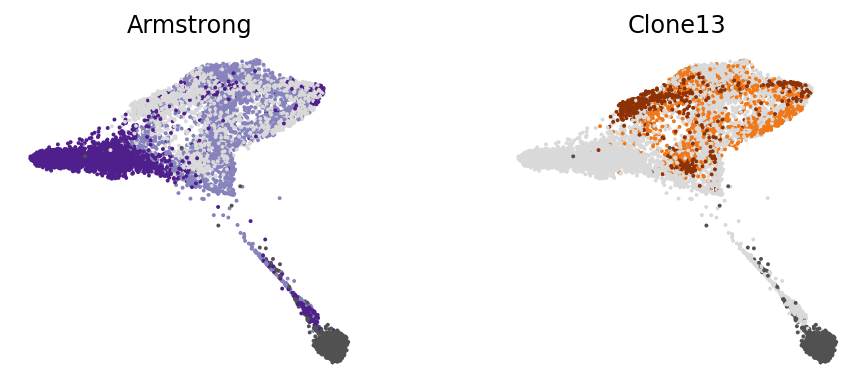

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

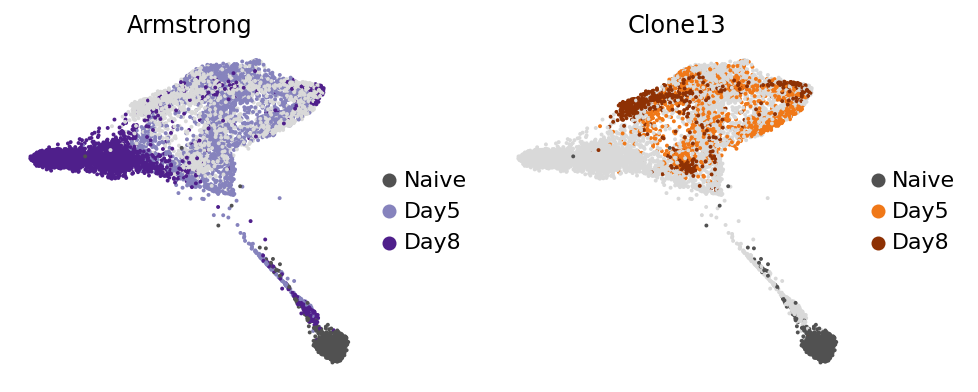

In [8]:
### Hightlight by day
save_name = '_Arm_vs_Cl13---byDay'

### Plot
adata.obs['Armstrong'] = [x if "C" not in x else "" for x in adata.obs['cell_type']]
adata.obs['Armstrong'] = ["Naive" if x == 'NP14B' else "" if x == "" else "Day%s"%x[1] for x in adata.obs['Armstrong']]
adata.obs['Armstrong'] = pd.Categorical(adata.obs['Armstrong'].tolist(), categories=['', 'Naive','Day5', 'Day8']) 
adata.uns['Armstrong_colors'] = [plt.cm.Greys(0.25), plt.cm.Greys(0.75), plt.cm.Purples(0.6), plt.cm.Purples(0.9)]

adata.obs['Clone13'] = [x if "A" not in x else "" for x in adata.obs['cell_type']]
adata.obs['Clone13'] = ["Naive" if x == 'NP14B' else "" if x == "" else "Day%s"%x[1] for x in adata.obs['Clone13']]
adata.obs['Clone13'] = pd.Categorical(adata.obs['Clone13'].tolist(), categories=['', 'Naive','Day5', 'Day8']) 
adata.uns['Clone13_colors'] = [plt.cm.Greys(0.25), plt.cm.Greys(0.75), plt.cm.YlOrBr(0.6),  plt.cm.YlOrBr(0.9)]

rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['Armstrong', 'Clone13'], frameon=False, save=save_name + '.png',  legend_loc=None)
sc.pl.draw_graph(adata, color=['Armstrong', 'Clone13'], frameon=False, save=save_name + '.pdf')

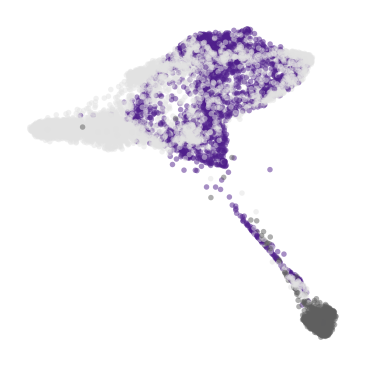

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


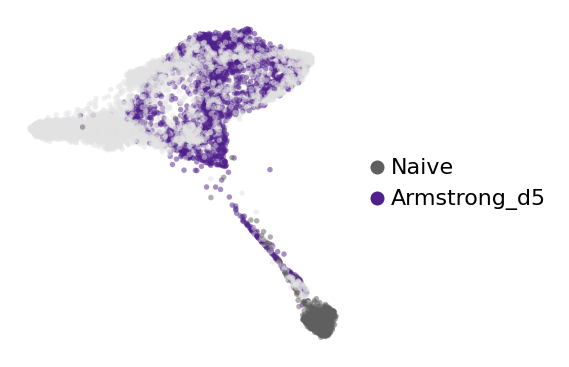

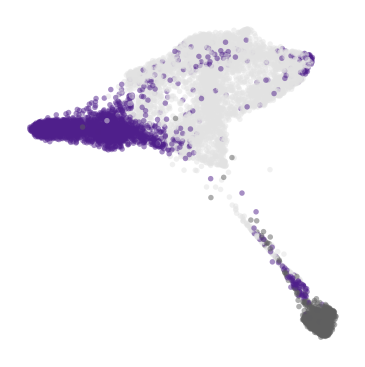

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


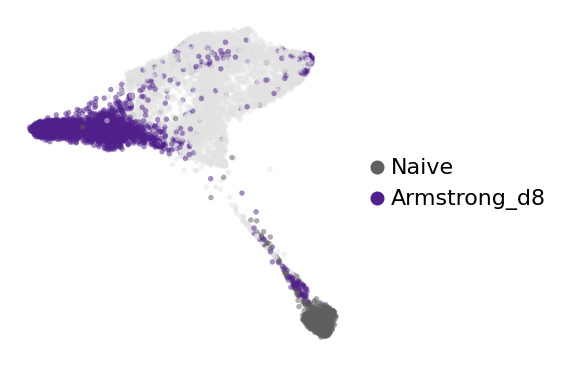

In [14]:
### Hightlight by day
adata.obs['Armstrong_d5'] = [x if x in ['NP14B', 'A5P','A5T'] else '' for x in adata.obs['cell_type']]
adata.obs['Armstrong_d5'] = ['Naive' if x == 'NP14B' else '' if x == '' else 'Armstrong d5' for x in adata.obs['Armstrong_d5']]
adata.obs['Armstrong_d5'] = pd.Categorical(adata.obs['Armstrong_d5'].tolist(), categories=['', 'Naive','Armstrong_d5']) 
adata.uns['Armstrong_d5_colors'] = [plt.cm.Greys(0.2), plt.cm.Greys(0.7), plt.cm.Purples(0.9)]

adata.obs['Armstrong_d8'] = [x if x in ['NP14B', 'A8P','A8T'] else '' for x in adata.obs['cell_type']]
adata.obs['Armstrong_d8'] = ['Naive' if x == 'NP14B' else '' if x == '' else 'Armstrong d8' for x in adata.obs['Armstrong_d8']]
adata.obs['Armstrong_d8'] = pd.Categorical(adata.obs['Armstrong_d8'].tolist(), categories=['', 'Naive','Armstrong_d8']) 
adata.uns['Armstrong_d8_colors'] = [plt.cm.Greys(0.2), plt.cm.Greys(0.7), plt.cm.Purples(0.9)]


save_name = '_Arm---D5'
rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['Armstrong_d5'], frameon=False, legend_loc=None, title=['',''], save=save_name + '.png', alpha=0.5, s=30)
sc.pl.draw_graph(adata, color=['Armstrong_d5'], frameon=False, title=['',''], save=save_name + '.pdf',alpha=0.5,  s=30)

save_name = '_Arm---D8'
rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['Armstrong_d8'], frameon=False, legend_loc=None, title=['',''], save=save_name + '.png', alpha=0.5, s=30)
sc.pl.draw_graph(adata, color=['Armstrong_d8'], frameon=False, title=['',''], save=save_name + '.pdf', alpha=0.5, s=30)

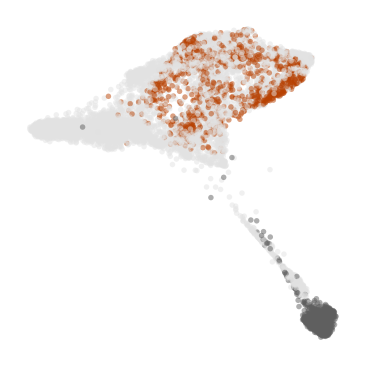

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


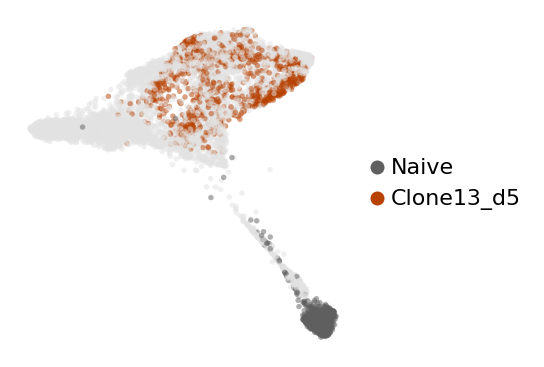

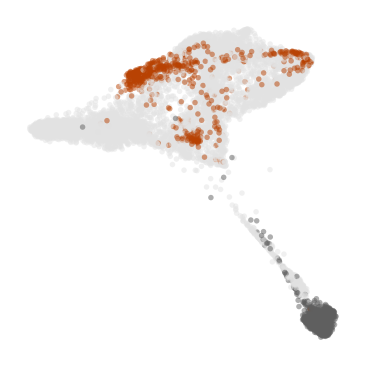

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


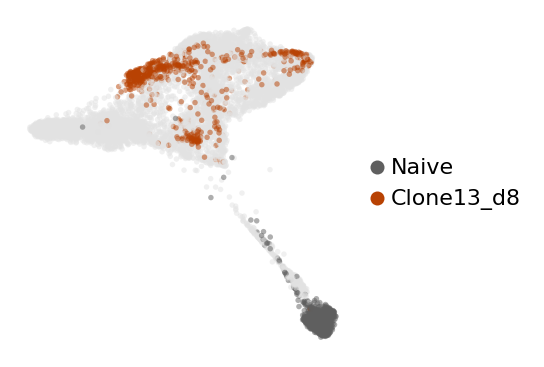

In [15]:
### Hightlight by day

adata.obs['Clone13_d5'] = [x if x in ['NP14B', 'C5P'] else '' for x in adata.obs['cell_type']]
adata.obs['Clone13_d5'] = ['Naive' if x == 'NP14B' else '' if x == '' else 'Armstrong d5' for x in adata.obs['Clone13_d5']]
adata.obs['Clone13_d5'] = pd.Categorical(adata.obs['Clone13_d5'].tolist(), categories=['', 'Naive','Clone13_d5']) 
adata.uns['Clone13_d5_colors'] = [plt.cm.Greys(0.2), plt.cm.Greys(0.7), plt.cm.YlOrBr(0.8)]

adata.obs['Clone13_d8'] = [x if x in ['NP14B', 'C8P'] else '' for x in adata.obs['cell_type']]
adata.obs['Clone13_d8'] = ['Naive' if x == 'NP14B' else '' if x == '' else 'Armstrong d8' for x in adata.obs['Clone13_d8']]
adata.obs['Clone13_d8'] = pd.Categorical(adata.obs['Clone13_d8'].tolist(), categories=['', 'Naive','Clone13_d8']) 
adata.uns['Clone13_d8_colors'] = [plt.cm.Greys(0.2), plt.cm.Greys(0.7), plt.cm.YlOrBr(0.8)]

save_name = '_Cl13---D5'
rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['Clone13_d5'], frameon=False, legend_loc=None, title=['',''], save=save_name + '.png', alpha=0.5, s=30)
sc.pl.draw_graph(adata, color=['Clone13_d5'], frameon=False, title=['',''], save=save_name + '.pdf', alpha=0.5, s=30)

save_name = '_Cl13---D8'
rcParams['figure.figsize'] = 3, 3
sc.pl.draw_graph(adata, color=['Clone13_d8'], frameon=False, legend_loc=None, title=['',''], save=save_name + '.png', alpha=0.5, s=30)
sc.pl.draw_graph(adata, color=['Clone13_d8'], frameon=False, title=['',''], save=save_name + '.pdf', alpha=0.5, s=30)

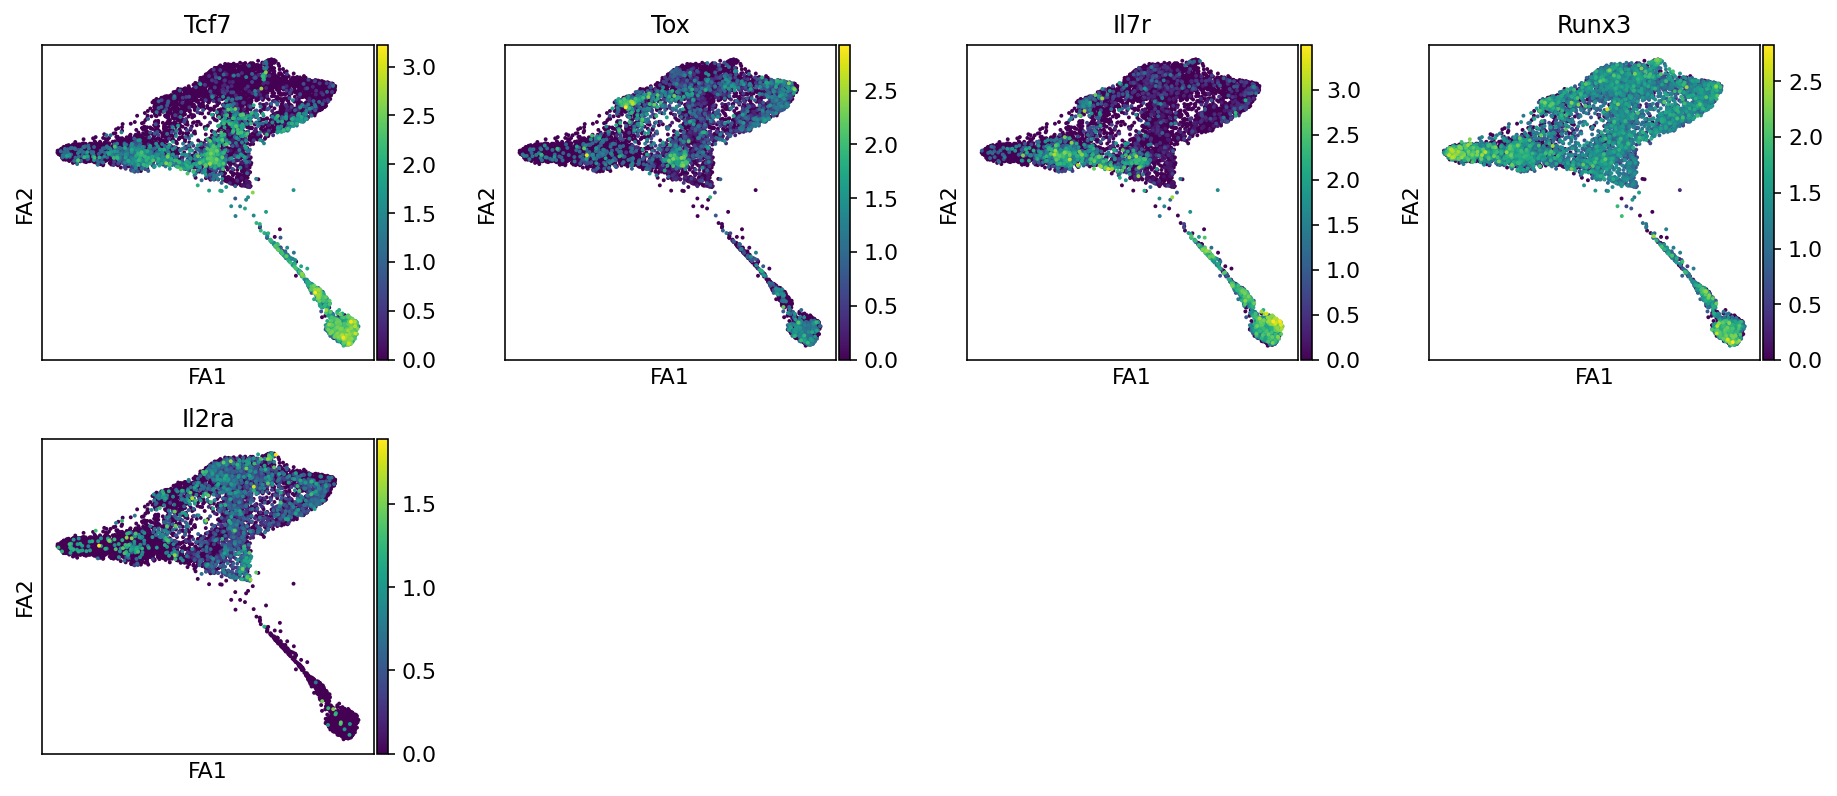

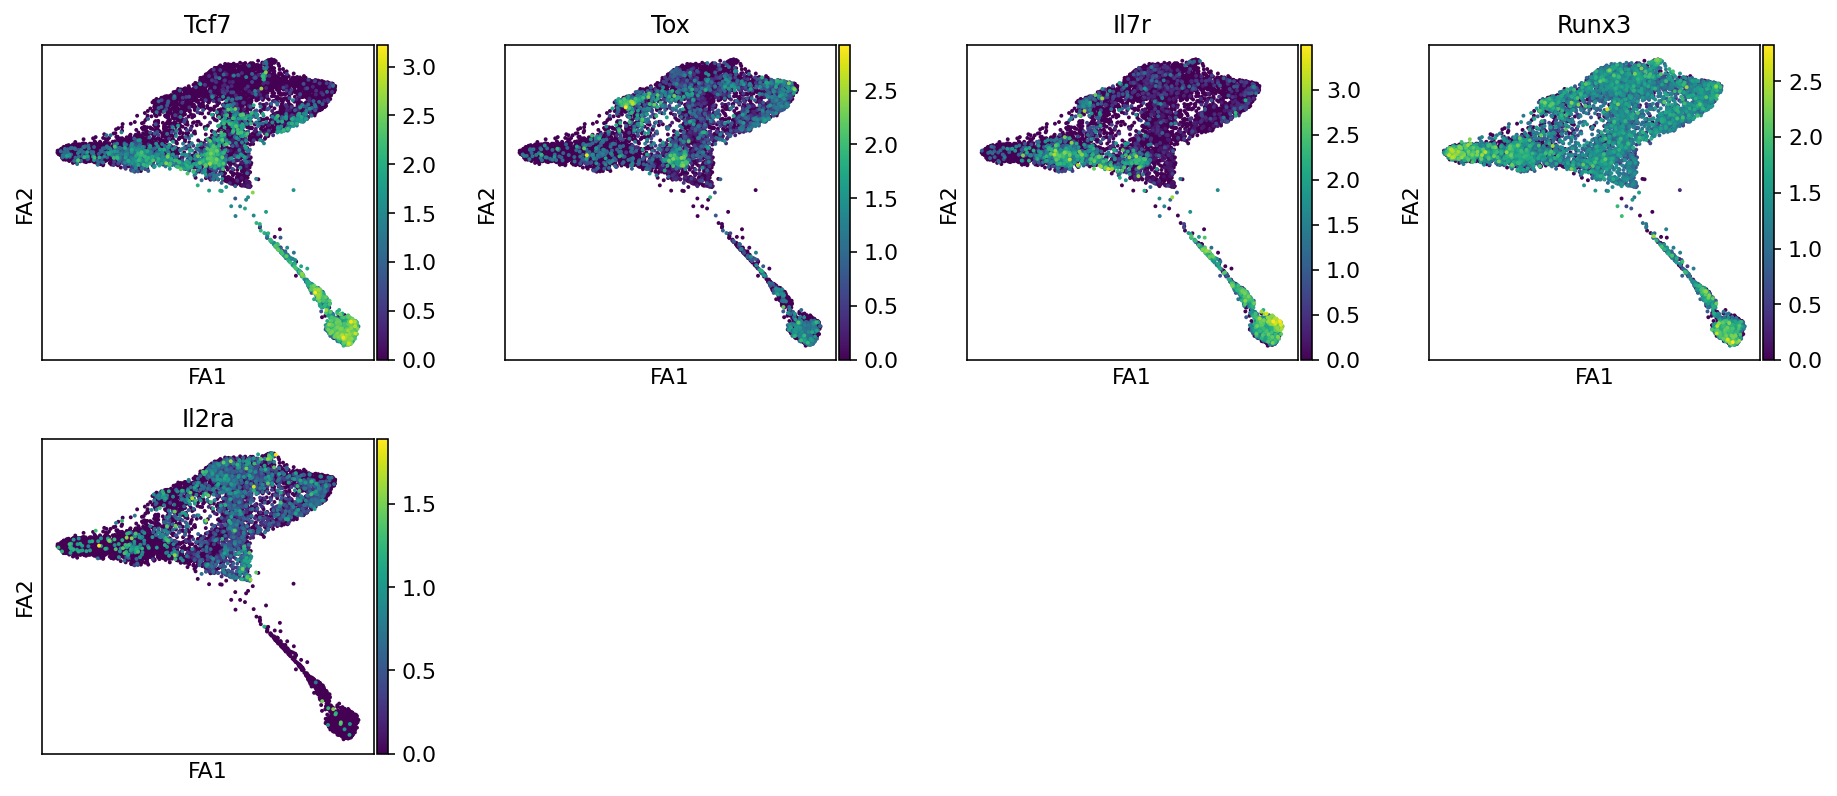

In [122]:
### Scatter plot with signature genes
save_name = 'Slt_genes_scatter'

### Plot
rcParams['figure.figsize'] = 3, 3
slt_genes = ['Tcf7', 'Tox', 'Il7r', 'Runx3', 'Il2ra']
sc.pl.draw_graph(adata, color=slt_genes, color_map='viridis', save=save_name + '.png')
sc.pl.draw_graph(adata, color=slt_genes, color_map='viridis', save=save_name + '.pdf')

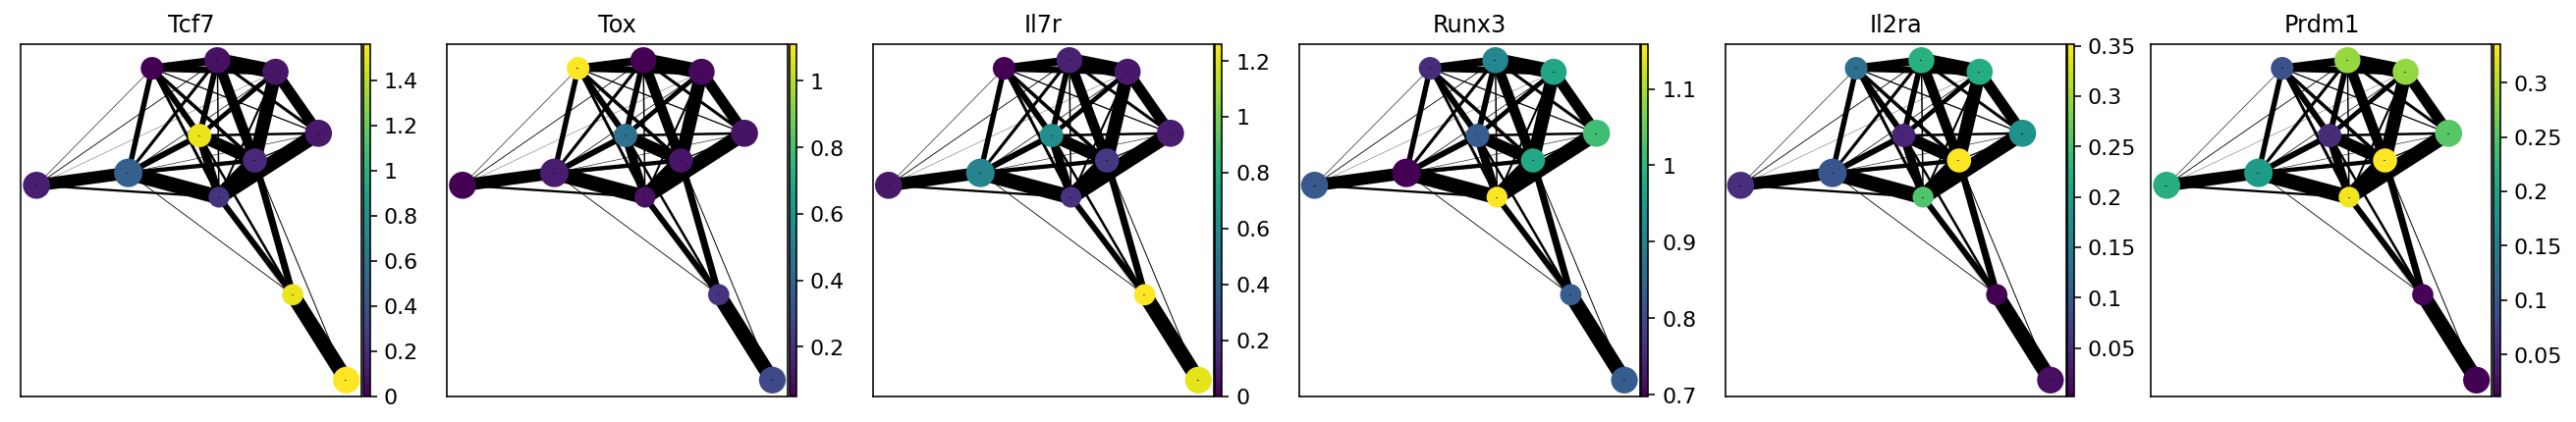

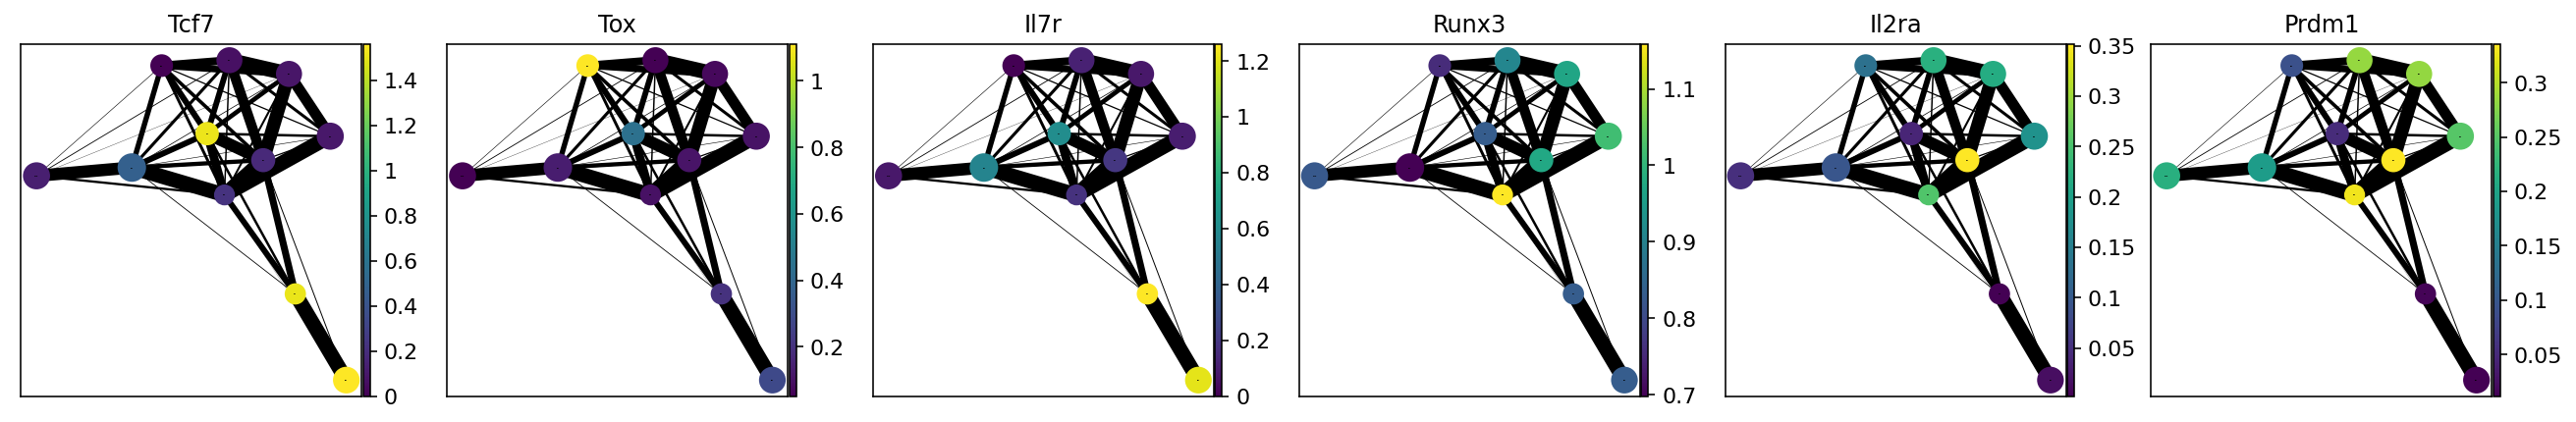

In [40]:
### Node plot with signature genes
save_name = 'Slt_genes_node'

### Plot
rcParams['figure.figsize'] = 3.3, 3
slt_genes = ['Tcf7', 'Tox', 'Il7r', 'Runx3', 'Il2ra', 'Prdm1']
sc.pl.paga(adata_arm, color=slt_genes, fontsize=0, cmap='viridis', save=save_name + '.png')
sc.pl.paga(adata_arm, color=slt_genes, fontsize=0, cmap='viridis', save=save_name + '.pdf')

... storing 'louvain_celltype' as categorical
... storing 'Infection type' as categorical


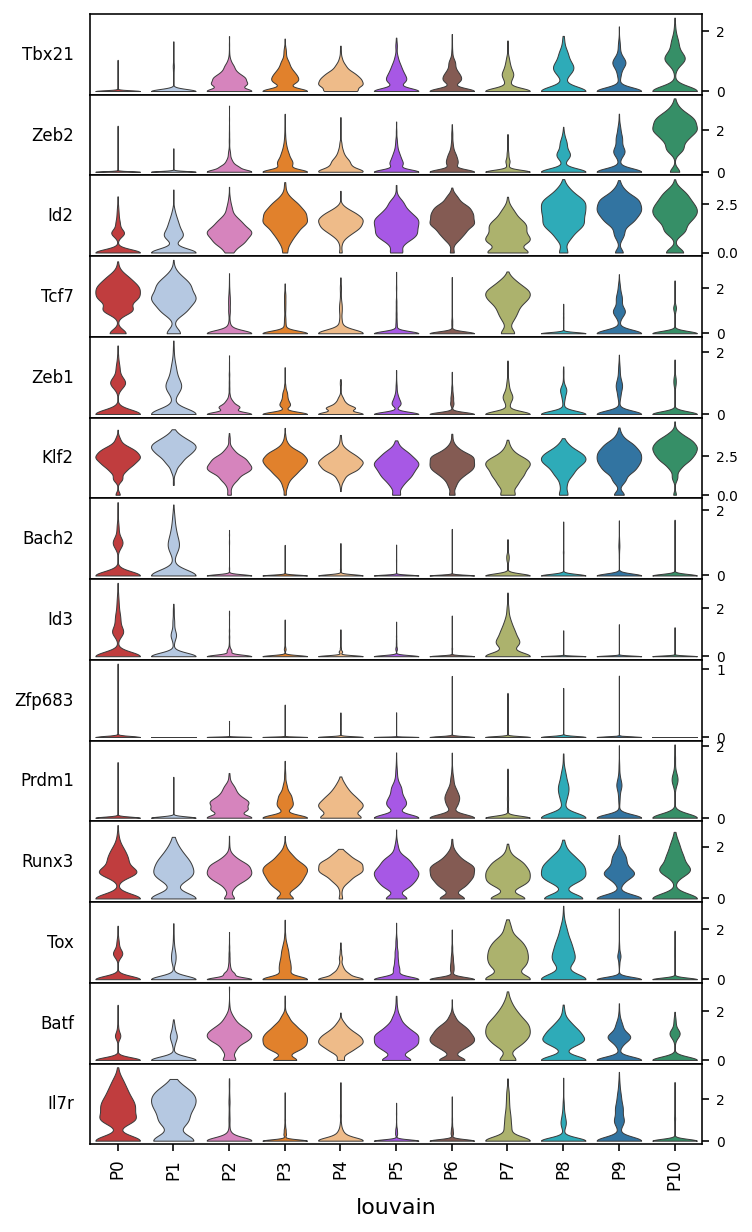

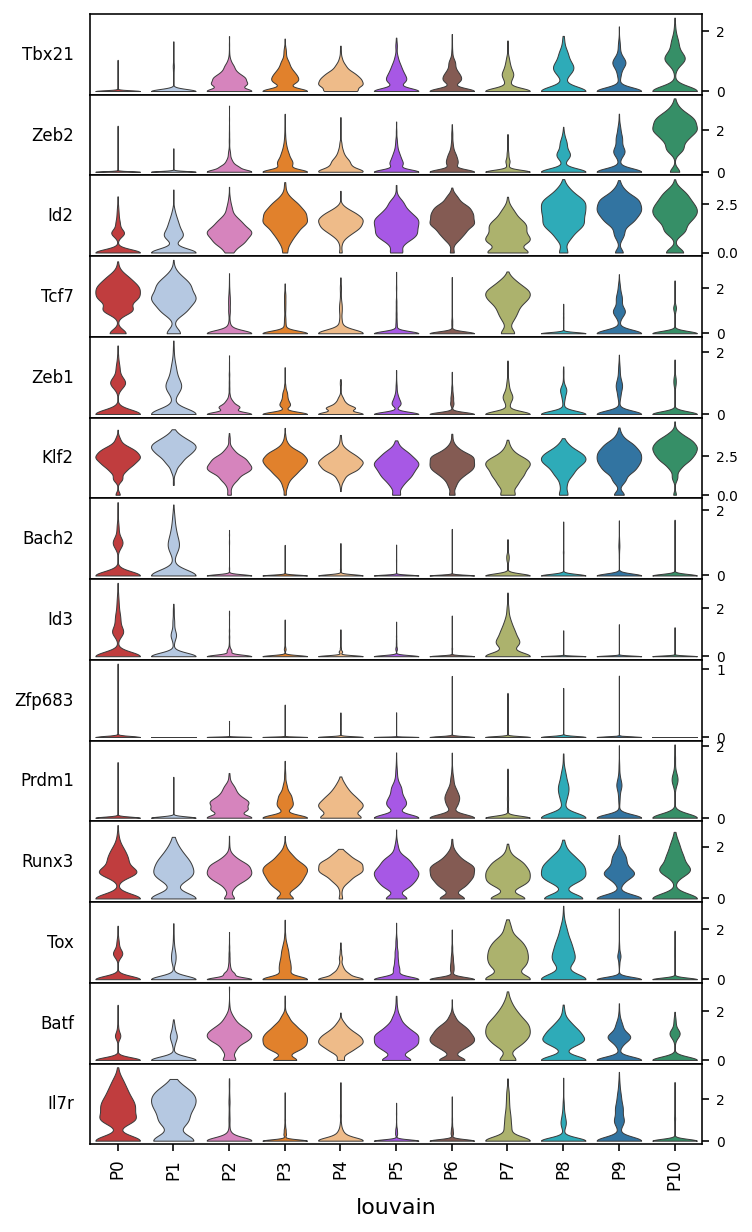

[<AxesSubplot:ylabel='Tbx21'>,
 <AxesSubplot:ylabel='Zeb2'>,
 <AxesSubplot:ylabel='Id2'>,
 <AxesSubplot:ylabel='Tcf7'>,
 <AxesSubplot:ylabel='Zeb1'>,
 <AxesSubplot:ylabel='Klf2'>,
 <AxesSubplot:ylabel='Bach2'>,
 <AxesSubplot:ylabel='Id3'>,
 <AxesSubplot:ylabel='Zfp683'>,
 <AxesSubplot:ylabel='Prdm1'>,
 <AxesSubplot:ylabel='Runx3'>,
 <AxesSubplot:ylabel='Tox'>,
 <AxesSubplot:ylabel='Batf'>,
 <AxesSubplot:xlabel='louvain', ylabel='Il7r'>]

In [25]:
### Violin plot with selected genes
save_name = 'Slt_genes_violin'

slt_genes = ['Tbx21', 'Zeb2', 'Id2', 'Tcf7', 'Zeb1', 'Klf2', 'Bach2', 'Id3', 'Zfp683', 'Prdm1', 'Runx3', 'Tox', 'Batf', 'Il7r']
sc.pl.stacked_violin(adata_neworder, slt_genes, groupby='louvain', swap_axes=True, cmap='Blues', palette=new_louvain_colors, figsize=(6,10), save=save_name + '.png')
sc.pl.stacked_violin(adata_neworder, slt_genes, groupby='louvain', swap_axes=True, cmap='Blues', palette=new_louvain_colors, figsize=(6,10), save=save_name + '.pdf')

In [33]:
adata_neworder_act = adata_neworder[adata_neworder.obs['cell_type'] != "NP14B"]

In [47]:
lcs_cats = []
for i in range(0, 11):
    lcs_cats += ["P%s_AT"%i, "P%s_AP"%i, "P%s_CP"%i]
lcs_list = [x+"_"+y[0]+y[-1] for index,(x,y) in enumerate(zip(adata_neworder_act.obs['louvain'], adata_neworder_act.obs['cell_type']))]
adata_neworder_act.obs['louvain_celltype_simp'] = pd.Categorical(lcs_list, categories = lcs_cats)

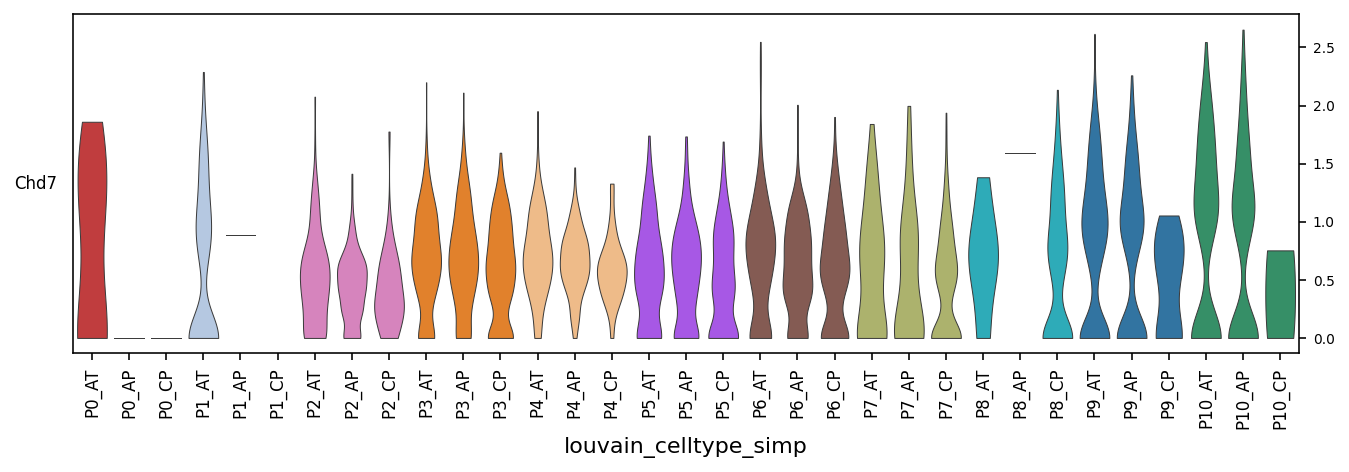

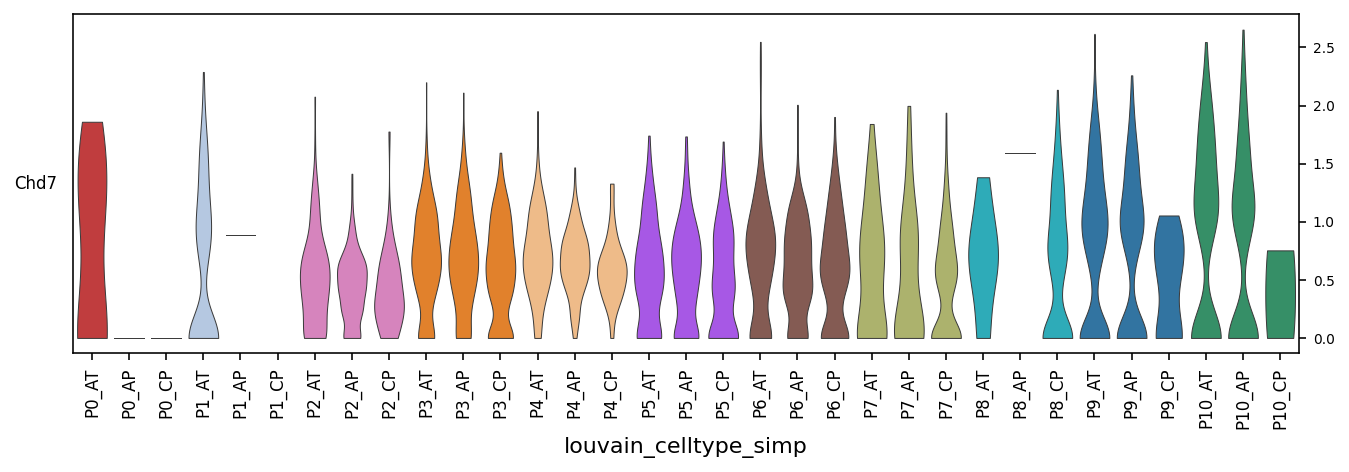

[<AxesSubplot:xlabel='louvain_celltype_simp', ylabel='Chd7'>]

In [48]:
### Violin plot with selected genes
save_name = 'Crf_violin'

slt_genes = ['Chd7']
sc.pl.stacked_violin(adata_neworder_act, slt_genes, groupby='louvain_celltype_simp', swap_axes=True, cmap='Blues', palette=np.repeat(new_louvain_colors,3), figsize=(12,3), save=save_name + '.png')
sc.pl.stacked_violin(adata_neworder_act, slt_genes, groupby='louvain_celltype_simp', swap_axes=True, cmap='Blues', palette=np.repeat(new_louvain_colors,3), figsize=(12,3), save=save_name + '.pdf')

In [51]:
lcs_cats = []
for i in range(0, 11):
    lcs_cats += ["P%s_A"%i, "P%s_C"%i]
lcs_list = [x+"_"+y[0] for index,(x,y) in enumerate(zip(adata_neworder_act.obs['louvain'], adata_neworder_act.obs['cell_type']))]
adata_neworder_act.obs['louvain_celltype_simp'] = pd.Categorical(lcs_list, categories = lcs_cats)

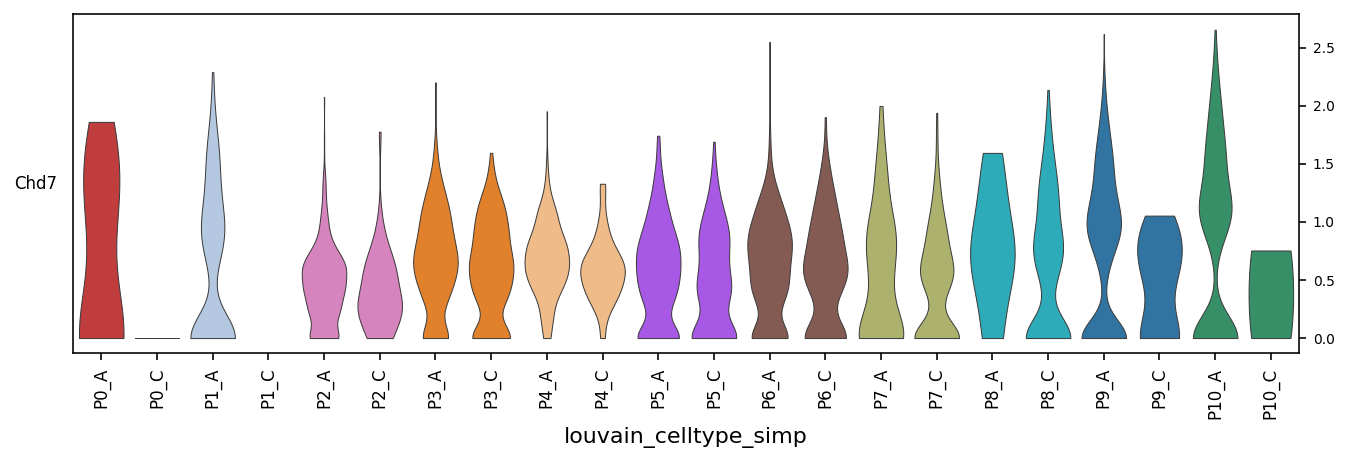

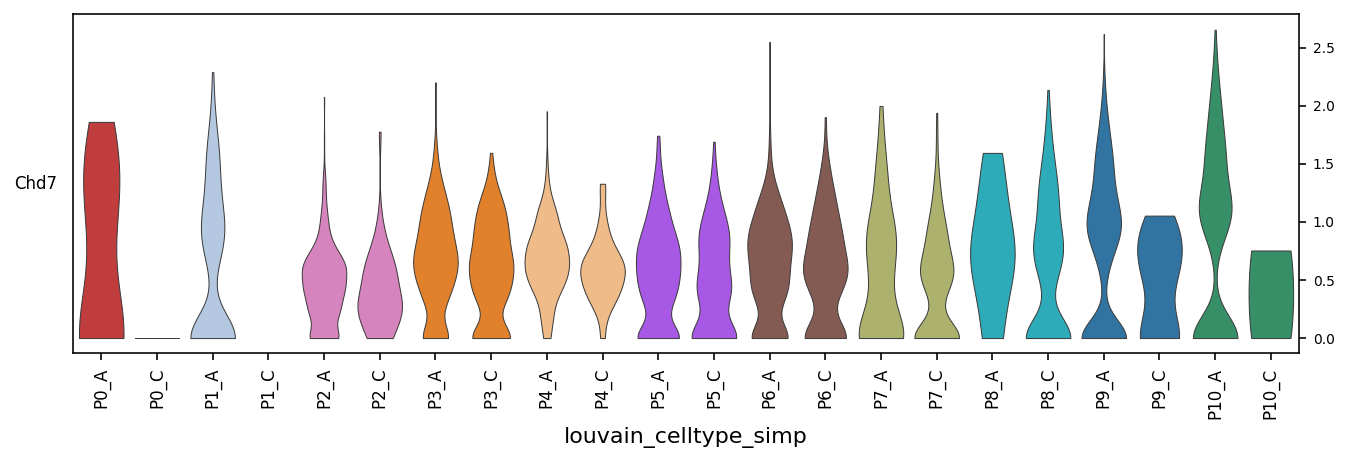

[<AxesSubplot:xlabel='louvain_celltype_simp', ylabel='Chd7'>]

In [53]:
### Violin plot with selected genes
save_name = 'Crf_simp_violin'

slt_genes = ['Chd7']
sc.pl.stacked_violin(adata_neworder_act, slt_genes, groupby='louvain_celltype_simp', swap_axes=True, cmap='Blues', palette=np.repeat(new_louvain_colors,2), figsize=(12,3), save=save_name + '.png')
sc.pl.stacked_violin(adata_neworder_act, slt_genes, groupby='louvain_celltype_simp', swap_axes=True, cmap='Blues', palette=np.repeat(new_louvain_colors,2), figsize=(12,3), save=save_name + '.pdf')

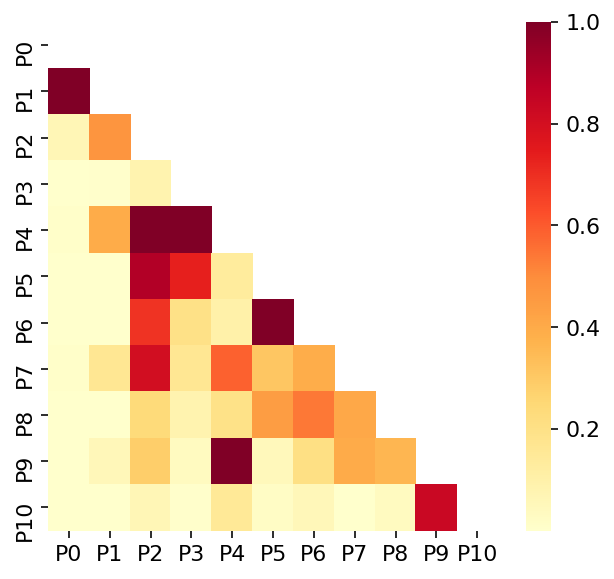

In [206]:
### Correlation heatmap
save_name = 'paga_corr'

### Plot
rcParams['figure.figsize'] = 5, 4.5

conn_df = pd.DataFrame.sparse.from_spmatrix(adata.uns['paga']['connectivities'])
conn_df.columns = old_louvain_order
conn_df.index = old_louvain_order
conn_df = conn_df[louvain_new_ordered]
conn_df = conn_df.loc[louvain_new_ordered]

mask = np.triu(np.ones_like(conn_df, dtype=bool))
corr_plot = sns.heatmap(conn_df, mask=mask, cmap="YlOrRd")
corr_plot.figure.savefig(save_name + ".png")
corr_plot.figure.savefig(save_name + ".pdf")

In [39]:
adata_neworder_plot = adata_neworder.copy()
adata_neworder_plot = adata_neworder_plot[adata_neworder_plot.obs['Infection type'] != "Naive"]
adata_neworder_plot = adata_neworder_plot[[True if x not in ["P0"] else False 
                                           for x in adata_neworder_plot.obs['louvain']]]
adata_neworder_plot = adata_neworder_plot[[True if x not in ['P8_A','P1_C', 'P9_C', 'P10_C'] else False
                                         for x in adata_neworder_plot.obs['louvain_celltype_general']]]

In [40]:
louvain_col_dict = {x:xcol for index, (x, xcol) in enumerate(zip(adata_neworder.obs['louvain'].cat.categories,
                                                                new_louvain_colors))}
col_palette = [louvain_col_dict[x.split("_")[0]] for x in 
               adata_neworder_plot.obs['louvain_celltype_general'].cat.categories]

Trying to set attribute `.obs` of view, copying.
... storing 'louvain_celltype' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'Infection type' as categorical


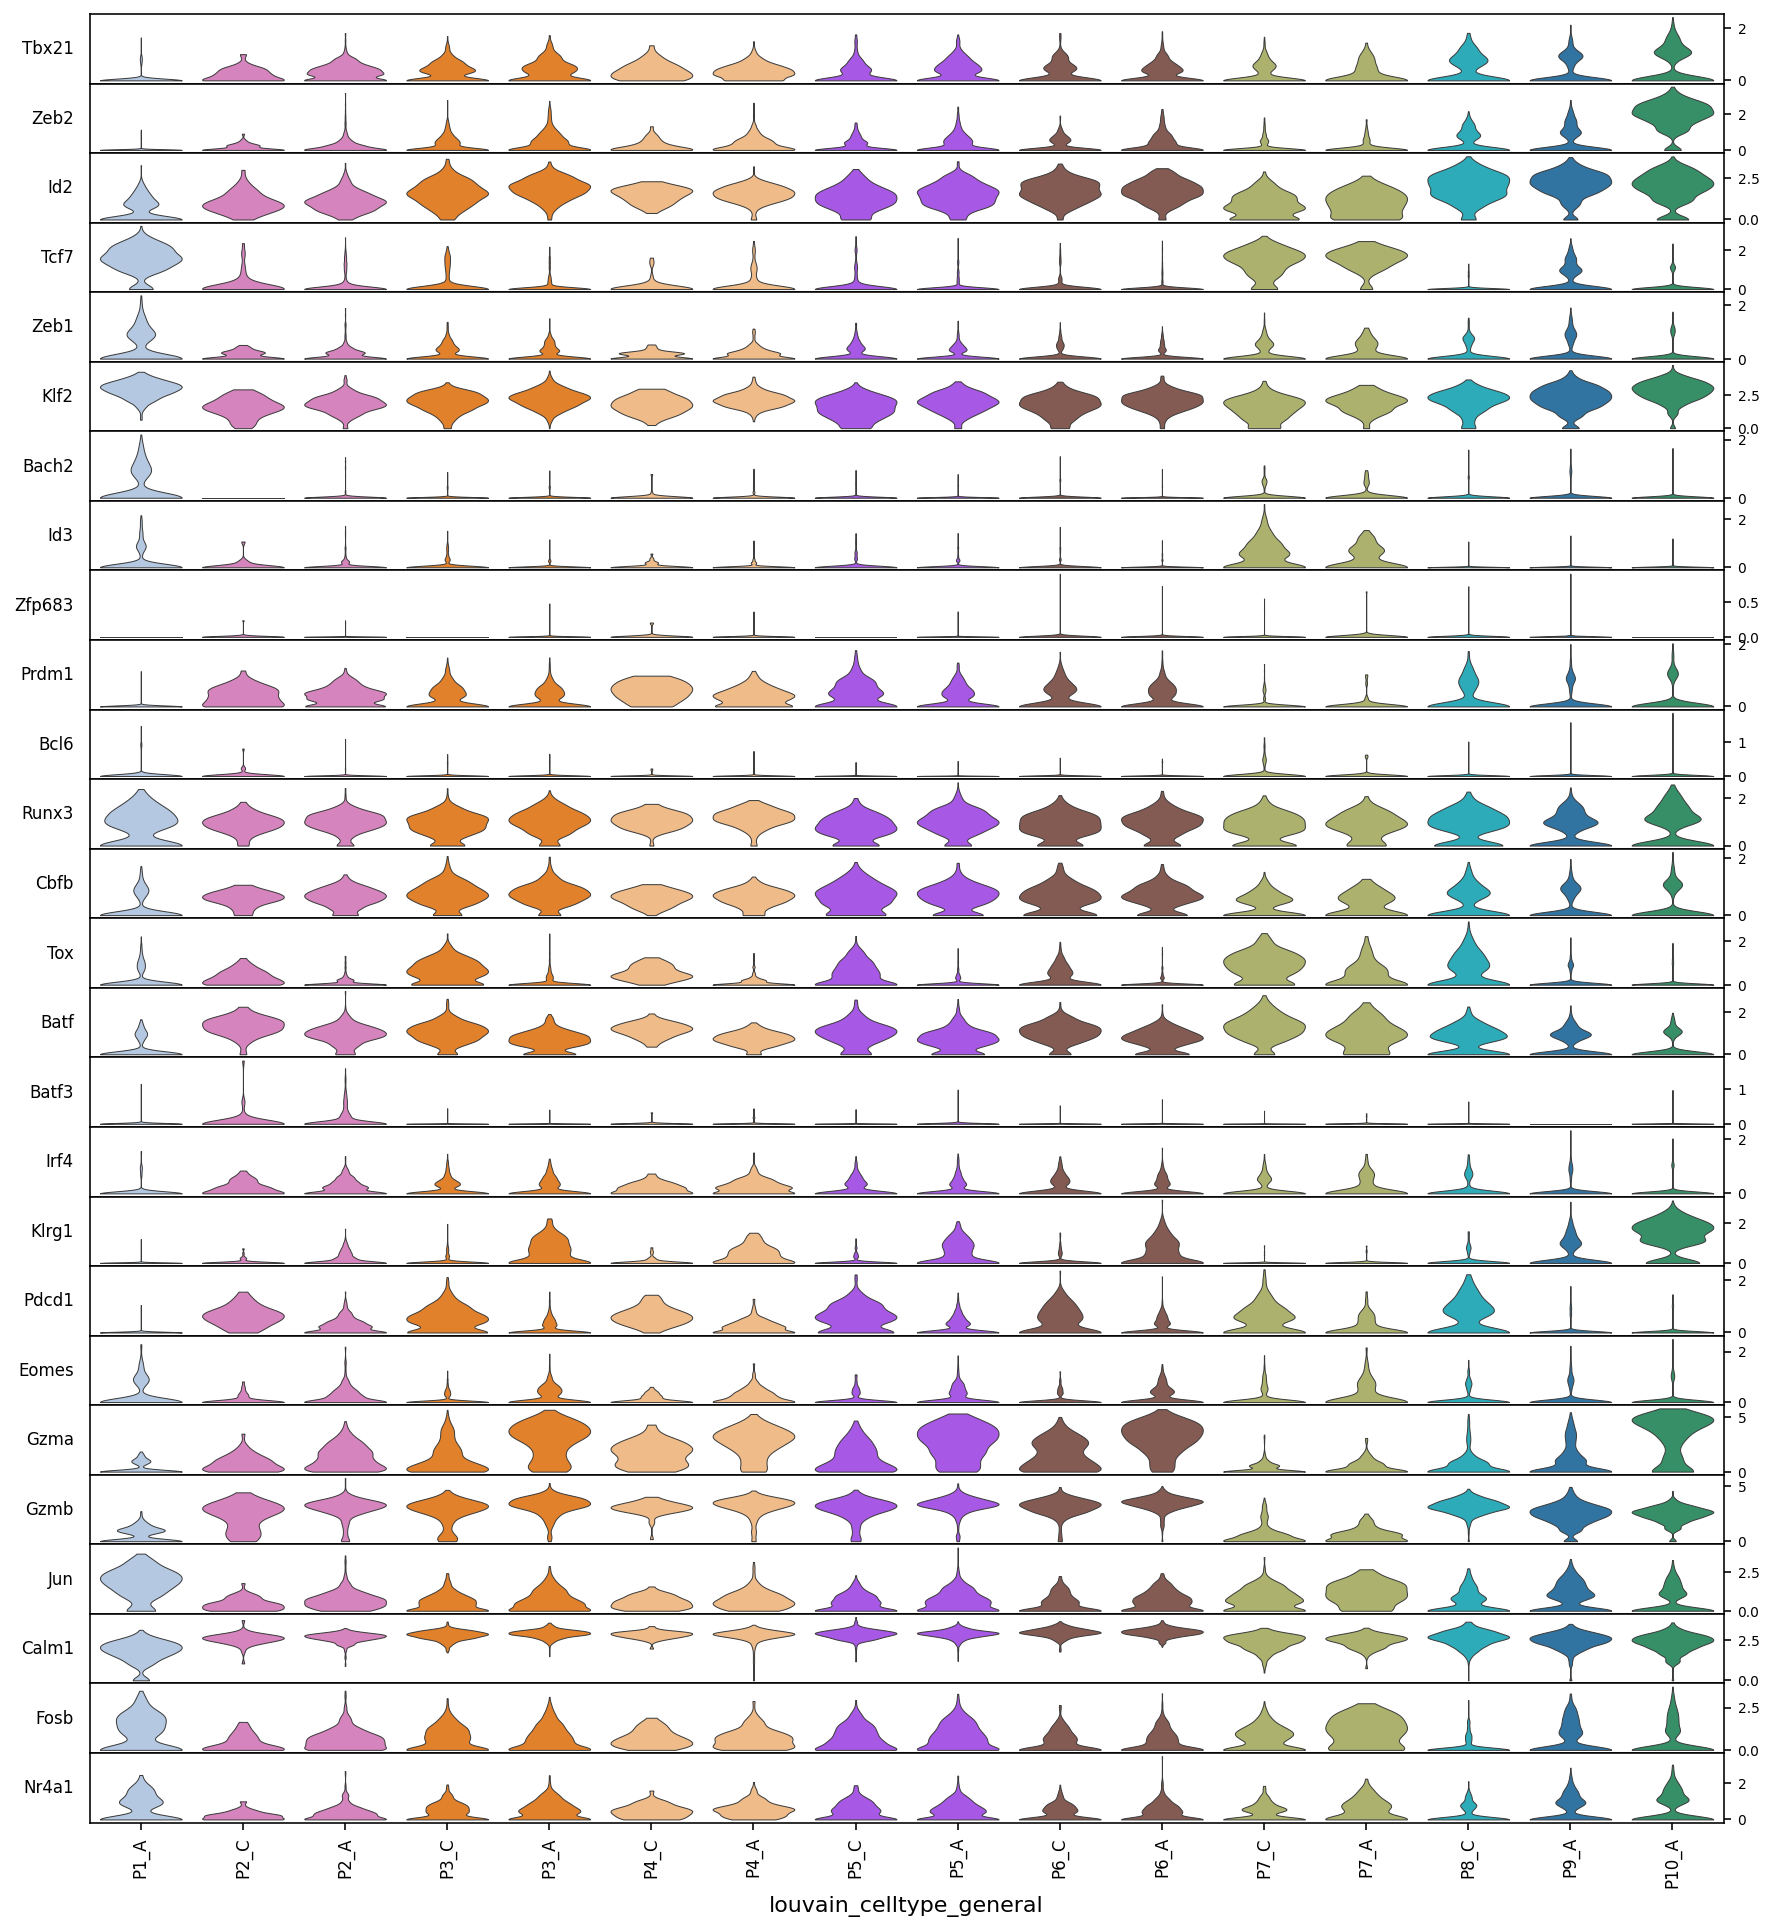

[<AxesSubplot:ylabel='Tbx21'>,
 <AxesSubplot:ylabel='Zeb2'>,
 <AxesSubplot:ylabel='Id2'>,
 <AxesSubplot:ylabel='Tcf7'>,
 <AxesSubplot:ylabel='Zeb1'>,
 <AxesSubplot:ylabel='Klf2'>,
 <AxesSubplot:ylabel='Bach2'>,
 <AxesSubplot:ylabel='Id3'>,
 <AxesSubplot:ylabel='Zfp683'>,
 <AxesSubplot:ylabel='Prdm1'>,
 <AxesSubplot:ylabel='Bcl6'>,
 <AxesSubplot:ylabel='Runx3'>,
 <AxesSubplot:ylabel='Cbfb'>,
 <AxesSubplot:ylabel='Tox'>,
 <AxesSubplot:ylabel='Batf'>,
 <AxesSubplot:ylabel='Batf3'>,
 <AxesSubplot:ylabel='Irf4'>,
 <AxesSubplot:ylabel='Klrg1'>,
 <AxesSubplot:ylabel='Pdcd1'>,
 <AxesSubplot:ylabel='Eomes'>,
 <AxesSubplot:ylabel='Gzma'>,
 <AxesSubplot:ylabel='Gzmb'>,
 <AxesSubplot:ylabel='Jun'>,
 <AxesSubplot:ylabel='Calm1'>,
 <AxesSubplot:ylabel='Fosb'>,
 <AxesSubplot:xlabel='louvain_celltype_general', ylabel='Nr4a1'>]

In [41]:
### Violin plot with marker genes
save_name = 'Marker_genes_violin'

slt_genes = ['Tbx21', 'Zeb2', 'Id2', 'Tcf7', 'Zeb1', 'Klf2', 'Bach2', 'Id3', 'Zfp683', 'Prdm1', 'Bcl6','Runx3', 'Cbfb', 
             'Tox', 'Batf', 'Batf3', 'Irf4', 'Klrg1','Pdcd1','Eomes','Gzma', 'Gzmb', 'Jun', 'Calm1', 'Fosb', 'Nr4a1']
sc.pl.stacked_violin(adata_neworder_plot, slt_genes, groupby='louvain_celltype_general', swap_axes=True, cmap='Blues', palette=col_palette, 
                     figsize=(16,16), save=save_name + '.png')

## 2. Distribution

In [8]:
adata.obs['cell_type_plot'] = ['Naive' if x =='NP14B' else x for x in adata.obs['cell_type']]
adata.obs['cell_type_plot'] = [x[:2] if x != 'Naive' else x for x in adata.obs['cell_type_plot']]
cell_type_plot_order = ['Naive', 'A5', 'A8', 'C5', 'C8']
adata.obs['cell_type_plot'] = pd.Categorical(adata.obs['cell_type_plot'].tolist(), categories=cell_type_plot_order)

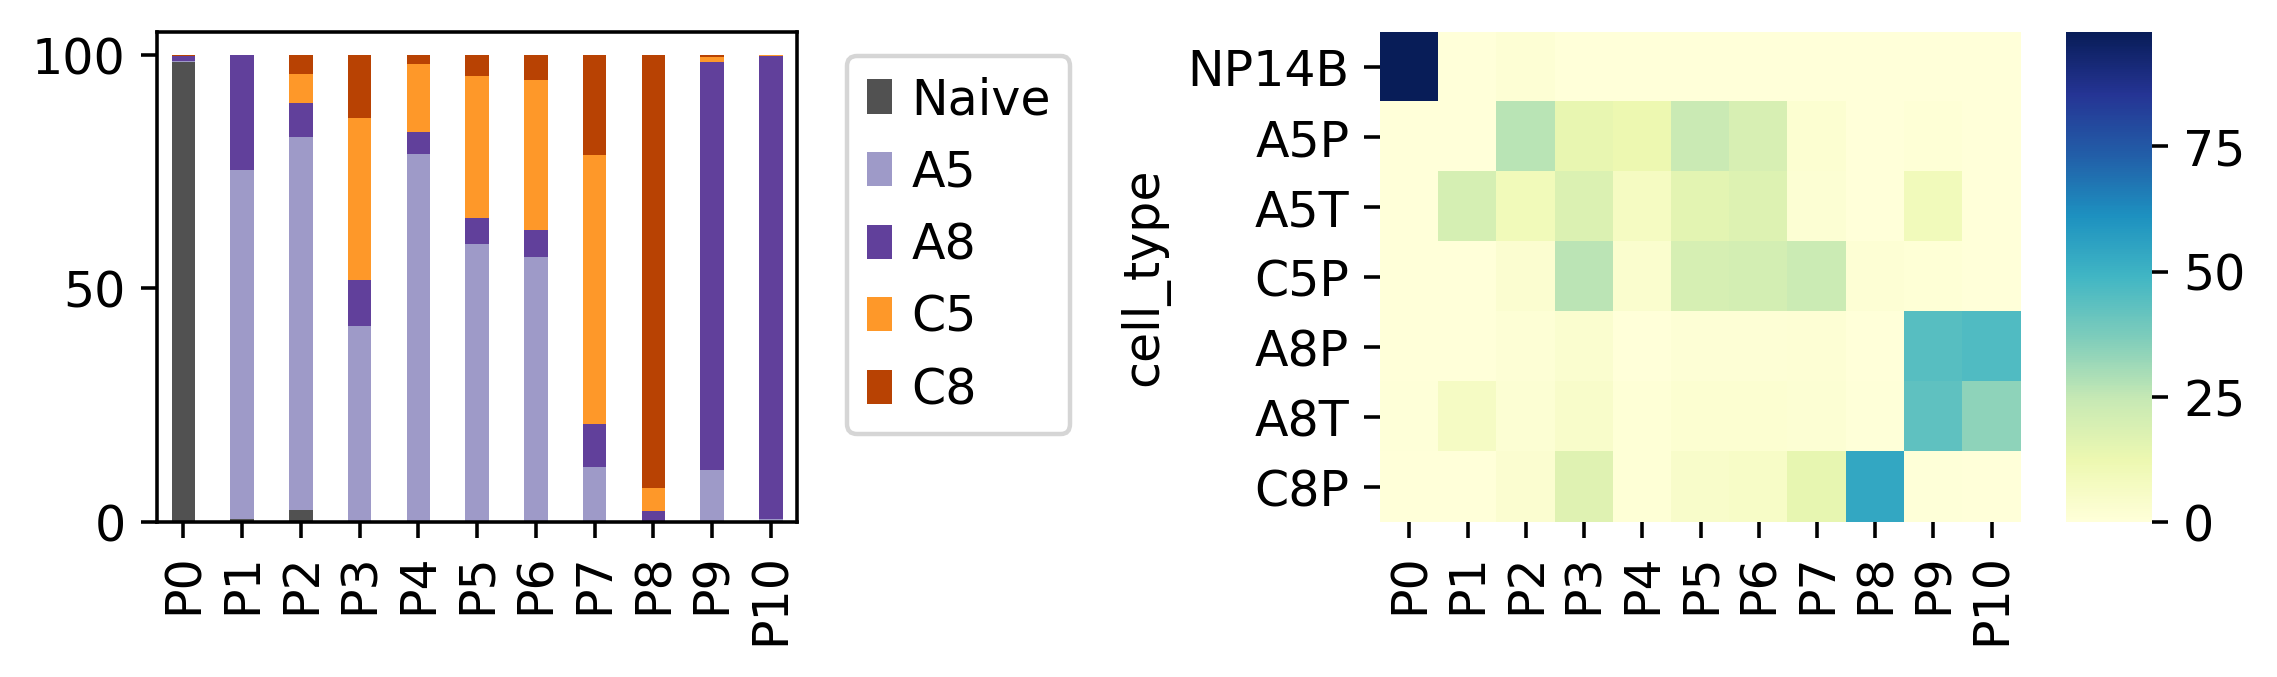

In [9]:
### Hightlight by day
save_name = 'Louvain_cell-type_distribution'

### Plot
fig, axes = plt.subplots(ncols=2, nrows=1, sharey=False, figsize=(7,2), constrained_layout = True, dpi=160)

col_list = [plt.cm.Greys(0.75), plt.cm.Purples(0.5), plt.cm.Purples(0.8),  plt.cm.YlOrBr(0.5),  plt.cm.YlOrBr(0.8)]
sum_df = sc_pl_addons.count_pctg_stack_bars(adata,  'louvain', 'cell_type_plot','cell_id', 
                                   None, None, axes[0], col_list,True)

key1 = 'louvain'
key2 = 'cell_type'
count = 'cell_id'
sum_df = adata.obs.reset_index()[[key1, key2, count]].drop_duplicates(count).groupby([key1, key2]).count()[[count]].unstack(key1)
sum_df.columns = [x[1] for x in sum_df.columns.values] 
sum_df[np.isnan(sum_df)] = 0
for i in range(0, len(sum_df)):
    sum_df.iloc[i] = sum_df.iloc[i] / sum(sum_df.iloc[i]) * 100
sum_df_cols = sum_df.columns.tolist()
sum_df_cols = sorted(sum_df_cols, key=lambda x: int(re.findall("\d+", x)[0]))
sum_df = sum_df[sum_df_cols]

sum_df_plot = sum_df.loc[['NP14B','A5P', 'A5T', 'C5P', 'A8P', 'A8T', 'C8P'], :]
sum_df_plot.to_csv(save_name + ".csv")
sns.heatmap(sum_df_plot, cmap='YlGnBu', ax=axes[1])

plt.show()
fig.savefig(save_name + '.png')
fig.savefig(save_name + '.pdf')
plt.close()

In [15]:
from dictances import bhattacharyya_coefficient

In [57]:
###----- Calculate distribution similarity between cell types
sum_df_prob = sum_df / 100
cell_types = ['NP14B','A5P', 'A5T', 'C5P', 'A8P', 'A8T', 'C8P']

bc_df = pd.DataFrame({'cell_type':cell_types}).set_index('cell_type')
for i in cell_types:
    i_bc = []
    for j in cell_types:
        i_bc.append(bhattacharyya_coefficient(sum_df_prob.loc[i], sum_df_prob.loc[j]))
    bc_df[i] = i_bc

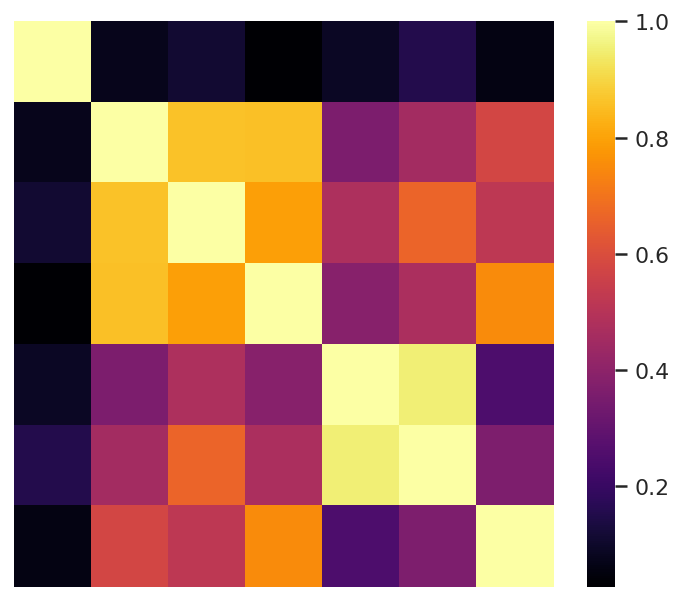

In [60]:
save_name = 'Louvain_cell-type_distribution_bhattacharyya-coefficient'

sns.set(rc={'figure.figsize':(6,5)})
bc_heatmap = sns.heatmap(bc_df, cmap='inferno')
bc_heatmap.set(xticklabels=[],yticklabels=[],ylabel='')

plt.savefig(save_name + '.png')

## 3. Expression heatmap

In [42]:
#gs_plot_use_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/Y_annotated/anno_plotuse_gs_20200928.csv'
#gs_plot_use_df = pd.read_csv(gs_plot_use_file)
#gs_use = gs_plot_use_df[gs_plot_use_df['plot_use'].notnull()]['gs_name'].tolist()

#gs_file = '/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/X_GeneSignatures_mm/all_mouse_T_cell_signatures.csv'
#gs_df = pd.read_csv(gs_file)
#gs_df_use = gs_df[[True if x in gs_use else False for x in gs_df['gs_name']]]
#genes_use = list(set(gs_df_use['gene_symbol'].tolist()))

### Intersect chromatin regulators & TF & cell surface receptors
surface_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/SurfaceMarkers_Cytokines/master/2_compiled/MM_MARKERS.csv')
surface_genes = surface_df['gene_name'].tolist()
crf_df = pd.read_csv('https://raw.githubusercontent.com/ScrippsPipkinLab/CRF_Screen/master/Ref/CRF_all.csv')
crf_genes = crf_df['gene_name'].tolist() + [x for x in crf_df['Alternative'].tolist() if str(x) != 'nan']
tf_df = pd.read_csv('https://raw.githubusercontent.com/Yolanda-HT/TFclassDataCollection/master/Ravasi_TF.csv')
tf_genes = tf_df['symbol'].tolist()
all_genes = list(set(surface_genes + crf_genes + tf_genes))

genes_use = all_genes

In [43]:
diff_dir = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/2_DE/eachCluster_vs_All'
diff_files = glob.glob("%s/*.csv"%diff_dir)
diff_files = [x for x in diff_files if "P" not in x.split("/")[-1]]

padj_list = ['wilcoxon_padj', 't-test_padj', 't-test_overestim_var_padj']
fc = 't-test_logfc'

louvain_sig_genes_plot_dict = {}
for i in diff_files:
    i_name = i.split("/")[-1].split("_")[0]
    
    i_df = pd.read_csv(i)


    i_df_sig = i_df
    for padj in padj_list:
        i_df_sig = i_df_sig[i_df_sig[padj] <= 0.05]

    i_df_sig = i_df_sig[i_df_sig[fc] > 0.5]

    i_df_sig_use = i_df_sig[[True if x in genes_use else False for x in i_df_sig['gene_names']]] # Select only the genes that are in GSEA
    #i_df_sig_use = i_df_sig[[False if (x.startswith("Rps") or x.startswith("Rpl")) else True for x in i_df_sig['gene_names']]] # Remove genes that are ribosomal
    i_df_sig_use = i_df_sig_use.sort_values(['t-test_score'], ascending=False)
    
    louvain_sig_genes_plot_dict[i_name] = pd.Series(i_df_sig_use['gene_names'].tolist())
    print("%s: %s signature genes"%(i_name, len(i_df_sig_use)))
louvain_sig_genes_plot_df = pd.DataFrame(louvain_sig_genes_plot_dict)
louvain_sig_genes_plot_df.to_csv("louvain_signature_genes.csv", index=False)

louvain_sig_genes_plot_df.columns = [louvain_new_ordered[louvain_old_ordered.index(int(x))] for x in louvain_sig_genes_plot_df.columns.tolist()]
louvain_sig_genes_plot_df = louvain_sig_genes_plot_df[louvain_new_ordered]
louvain_sig_genes_plot_df.to_csv("louvain_signature_genes_neworder.csv", index=False)

0: 96 signature genes
1: 248 signature genes
10: 261 signature genes
2: 79 signature genes
3: 97 signature genes
4: 203 signature genes
5: 113 signature genes
6: 325 signature genes
7: 130 signature genes
8: 99 signature genes
9: 79 signature genes


In [44]:
louvain_sig_genes_plot_df = pd.read_csv("louvain_signature_genes_neworder.csv")

... storing 'louvain_celltype' as categorical
... storing 'Infection type' as categorical


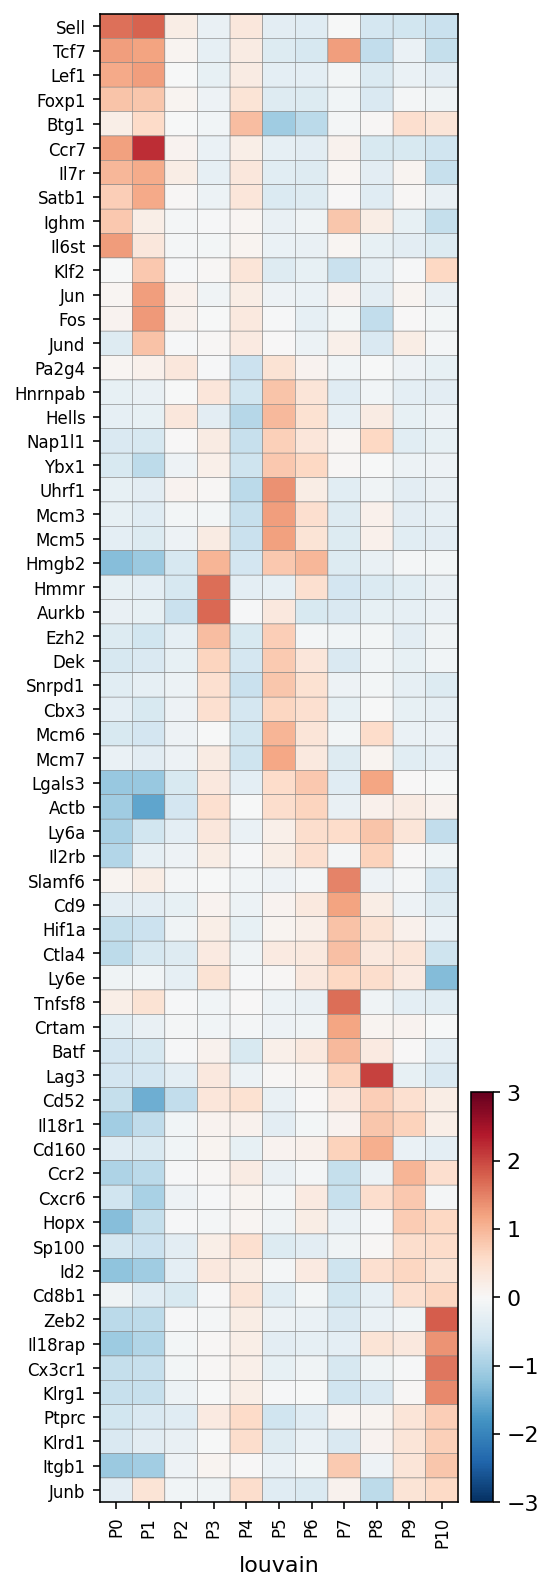

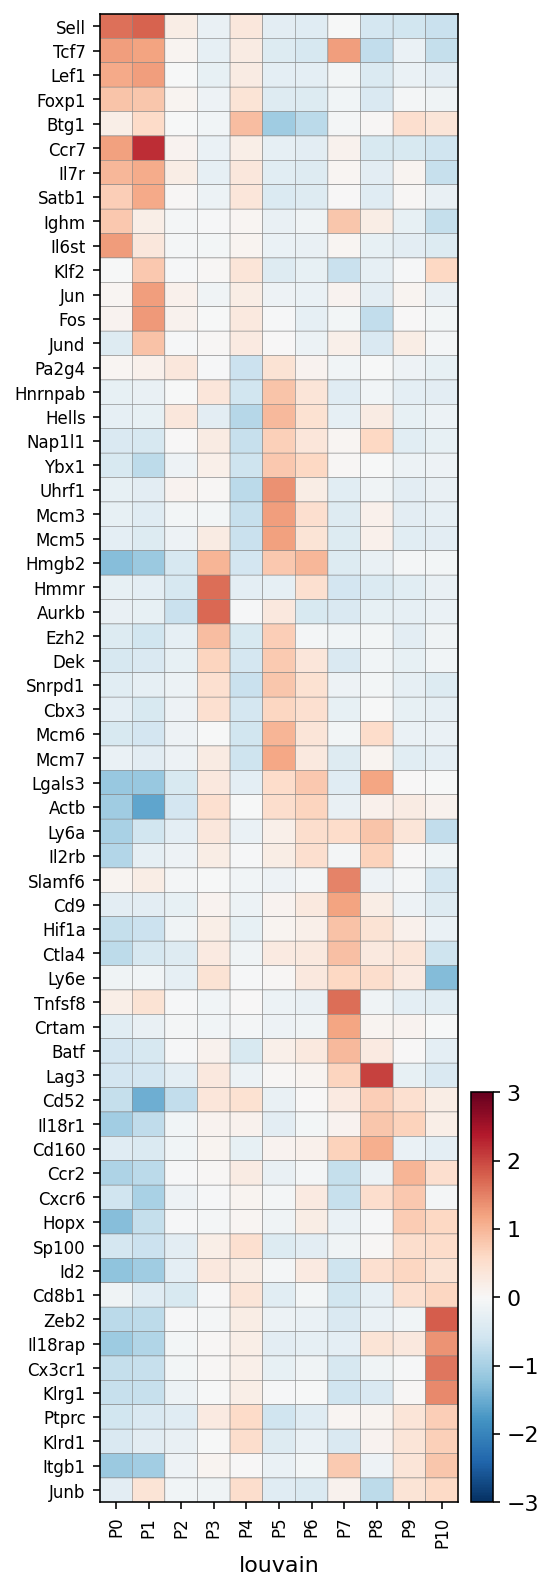

GridSpec(2, 3, height_ratios=[0, 12.200000000000001], width_ratios=[3.3, 0, 0.2])

In [45]:
### Heatmap for signature genes of louvain clusters
save_name = 'Louvain_cluster_signature_genes'

### Plot
marker_genes = []
for i in louvain_new_ordered:
    marker_genes = marker_genes + louvain_sig_genes_plot_df[i].tolist()[:10]
marker_genes = [ x for x in marker_genes if x in adata.var.index.tolist()]

marker_genes_use = []
for i in marker_genes:
    if i not in marker_genes_use:
        marker_genes_use.append(i)
        
adata_neworder.layers['scaled'] = sc.pp.scale(adata_neworder, copy=True).X
sc.pl.matrixplot(adata_neworder, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".png")
sc.pl.matrixplot(adata_neworder, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".pdf")

cell_type  n_genes  percent_mito  n_counts y_pred  use  \
AAACCCACACGACAAG-1     NP14B     2428      0.046283    9377.0   true  Yes   
AAACCCACAGAGGTAC-1       A8T     1992      0.041353    5441.0   true  Yes   
AAACCCACAGCCGTTG-1       A8T     2281      0.051667    6329.0   true  Yes   
AAACCCAGTGGGACAT-1       A8P     2247      0.037363    7280.0   true  Yes   
AAACCCATCGTGAGAG-1       A5P     4774      0.035462   30173.0   true  Yes   
...                      ...      ...           ...       ...    ...  ...   
TTTGGAGAGCGTACAG-1       A8P     4085      0.038608   18675.0   true  Yes   
TTTGGAGCAACTTGCA-1     NP14B     1527      0.055024    4707.0   true  Yes   
TTTGGTTGTCACTTAG-1       A8P     1944      0.057811    5345.0   true  Yes   
TTTGGTTTCCGCGATG-1       A8P     1760      0.020218    4402.0   true  Yes   
TTTGTTGCACACGGTC-1       A8P     2324      0.019778    6219.0   true  Yes   

                   louvain day  dpt_pseudotime louvain_celltype louvain_old  \
AAACCCACACGACAAG-1      P0   0        0.000000          3_NP14B           3   
AAACCCACAGAGGTAC-1     P10   8        0.950689            2_A8T           2   
AAACCCACAGCCGTTG-1      P7   8        0.893238            7_A8T           7   
AAACCCAGTGGGACAT-1      P9   8        0.907457            0_A8P           0   
AAACCCATCGTGAGAG-1      P2   5        0.898965            6_A5P           6   
...                    ...  ..             ...              ...         ...   
TTTGGAGAGCGTACAG-1      P9   8        0.938823            0_A8P           0   
TTTGGAGCAACTTGCA-1      P0   0        0.027301          3_NP14B           3   
TTTGGTTGTCACTTAG-1     P10   8        0.949120            2_A8P           2   
TTTGGTTTCCGCGATG-1     P10   8        0.947714            2_A8P           2   
TTTGTTGCACACGGTC-1      P9   8        0.934500            0_A8P           0   

                   Infection type             cell_id louvain_celltype_general  
AAACCCACACGACAAG-1          Naive  AAACCCACACGACAAG-1                     P0_N  
AAACCCACAGAGGTAC-1      Armstrong  AAACCCACAGAGGTAC-1                    P10_A  
AAACCCACAGCCGTTG-1      Armstrong  AAACCCACAGCCGTTG-1                     P7_A  
AAACCCAGTGGGACAT-1      Armstrong  AAACCCAGTGGGACAT-1                     P9_A  
AAACCCATCGTGAGAG-1      Armstrong  AAACCCATCGTGAGAG-1                     P2_A  
...                           ...                 ...                      ...  
TTTGGAGAGCGTACAG-1      Armstrong  TTTGGAGAGCGTACAG-1                     P9_A  
TTTGGAGCAACTTGCA-1          Naive  TTTGGAGCAACTTGCA-1                     P0_N  
TTTGGTTGTCACTTAG-1      Armstrong  TTTGGTTGTCACTTAG-1                    P10_A  
TTTGGTTTCCGCGATG-1      Armstrong  TTTGGTTTCCGCGATG-1                    P10_A  
TTTGTTGCACACGGTC-1      Armstrong  TTTGTTGCACACGGTC-1                     P9_A  

[5790 rows x 14 columns]

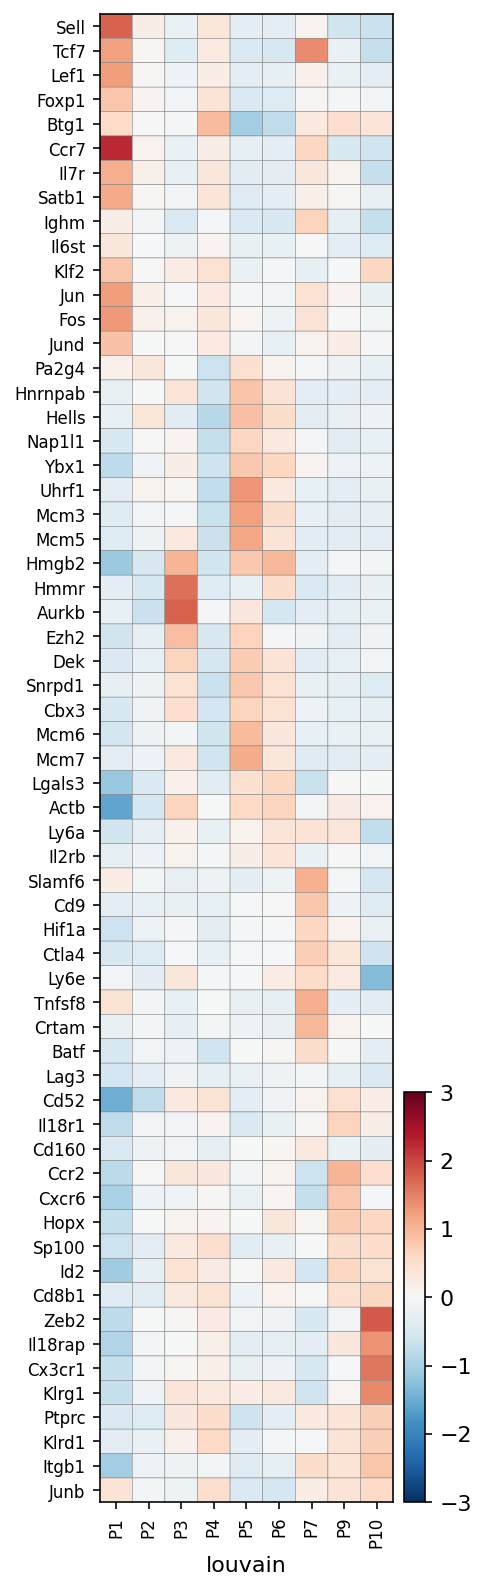

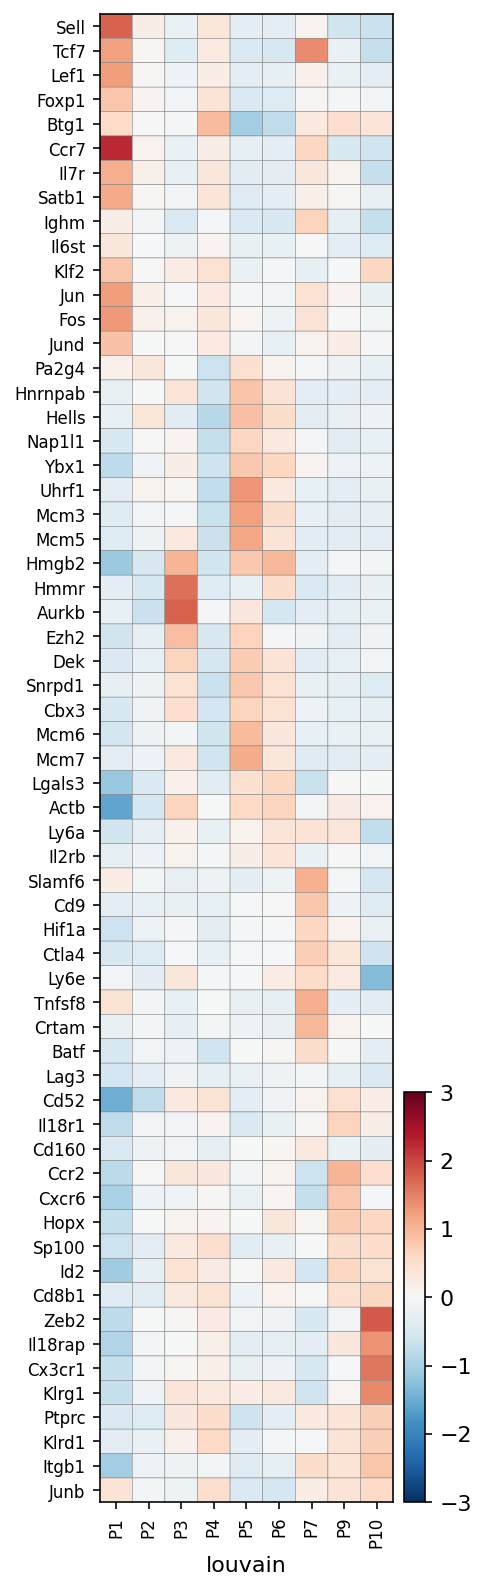

GridSpec(2, 3, height_ratios=[0, 12.200000000000001], width_ratios=[2.6999999999999997, 0, 0.2])

In [60]:
### Heatmap for signature genes of louvain clusters
save_name = 'Louvain_cluster_signature_genes_A'

### Plot
marker_genes = []
for i in louvain_new_ordered:
    marker_genes = marker_genes + louvain_sig_genes_plot_df[i].tolist()[:10]
marker_genes = [ x for x in marker_genes if x in adata.var.index.tolist()]

marker_genes_use = []
for i in marker_genes:
    if i not in marker_genes_use:
        marker_genes_use.append(i)
        

adata_neworder_A = adata_neworder[[True if ('C' not in x and 'N' not in x) else False 
                                   for x in adata_neworder.obs['cell_type']]]
adata_neworder_A = adata_neworder_A[[True if x not in ['P0_A','P8_A'] else False 
                                     for x in adata_neworder_A.obs['louvain_celltype_general']]]
#adata_neworder_A.layers['scaled'] = sc.pp.scale(adata_neworder_A, copy=True).X
sc.pl.matrixplot(adata_neworder_A, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".png")
sc.pl.matrixplot(adata_neworder_A, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".pdf")

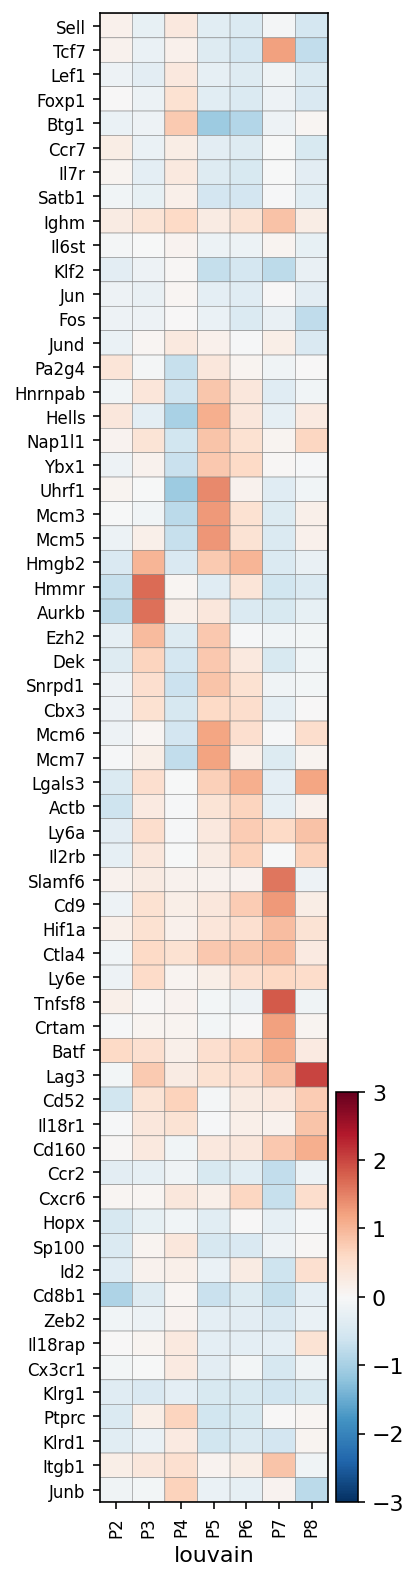

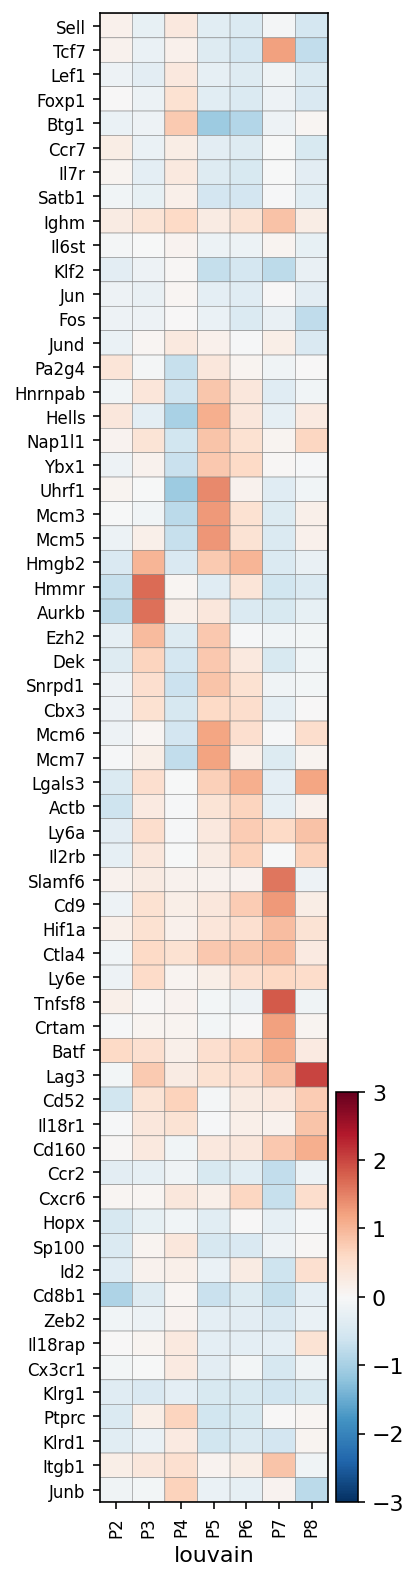

GridSpec(2, 3, height_ratios=[0, 12.200000000000001], width_ratios=[2.1, 0, 0.2])

In [61]:
### Heatmap for signature genes of louvain clusters
save_name = 'Louvain_cluster_signature_genes_C'

### Plot
marker_genes = []
for i in louvain_new_ordered:
    marker_genes = marker_genes + louvain_sig_genes_plot_df[i].tolist()[:10]
marker_genes = [ x for x in marker_genes if x in adata.var.index.tolist()]

marker_genes_use = []
for i in marker_genes:
    if i not in marker_genes_use:
        marker_genes_use.append(i)
        

adata_neworder_C = adata_neworder[[True if ('A' not in x and 'N' not in x) else False 
                                   for x in adata_neworder.obs['cell_type']]]
adata_neworder_C = adata_neworder_C[[True if x not in ['P0_C','P1_C', 'P9_C', 'P10_C'] else False 
                                     for x in adata_neworder_C.obs['louvain_celltype_general']]]
#adata_neworder_A.layers['scaled'] = sc.pp.scale(adata_neworder_A, copy=True).X
sc.pl.matrixplot(adata_neworder_C, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".png")
sc.pl.matrixplot(adata_neworder_C, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".pdf")

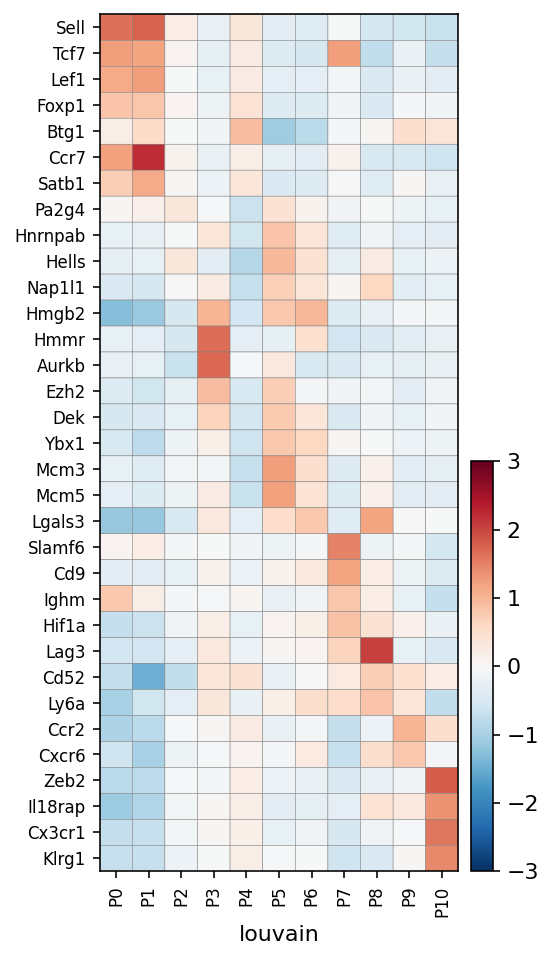

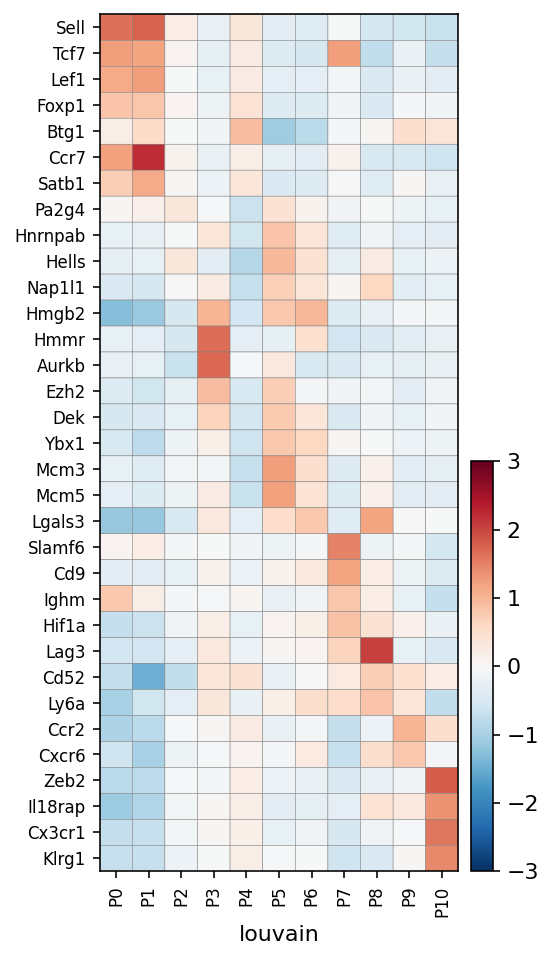

GridSpec(2, 3, height_ratios=[0, 6.6000000000000005], width_ratios=[3.3, 0, 0.2])

In [46]:
### Heatmap for signature genes of louvain clusters
save_name = 'Louvain_cluster_signature_genes_small'

### Plot
marker_genes = []
for i in louvain_new_ordered:
    marker_genes = marker_genes + louvain_sig_genes_plot_df[i].tolist()[:5]
marker_genes = [ x for x in marker_genes if x in adata.var.index.tolist()]

marker_genes_use = []
for i in marker_genes:
    if i not in marker_genes_use:
        marker_genes_use.append(i)
        
adata_neworder.layers['scaled'] = sc.pp.scale(adata_neworder, copy=True).X
sc.pl.matrixplot(adata_neworder, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".png")
sc.pl.matrixplot(adata_neworder, marker_genes_use, layer='scaled',groupby='louvain', vmin=-3, vmax=3, swap_axes=True, save=save_name + ".pdf")

# 4. GSEA node plot
## Per louvain cluster - Seperate Arm & Cl13

In [104]:
gsea_output = '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/0_resampled/louvain_celltype_sum_plot/louvain_celltype_gsea_all.csv'
gsea_output_df = pd.read_csv(gsea_output)

In [192]:
use_path = '2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up'
gsea_use_df = gsea_output_df[gsea_output_df['pathway'] == use_path]
gsea_use_df = gsea_use_df[[True if 'A5P' in x else False for x in gsea_use_df['comparison']]]
gsea_use_df['louvain'] = [x.split("_")[0] for x in gsea_use_df['comparison']]
gsea_use_df

comparison                                     pathway       NES  \
10       P9_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up -1.302685   
134      P3_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up  2.342110   
248      P4_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up -2.590711   
370     P10_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up  1.155559   
571      P5_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up  2.504452   
685      P6_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up  2.647048   
799      P2_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up -2.294118   
937      P7_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up -2.567349   
1049     P8_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up  1.201819   
1125     P1_A5P  2018_IMMUNITY_Wang---D5KLRG1lo_vs_Naive_up -2.407305   

          padj  leadingEdge_signal  mlog10padj old_names louvain  
10    0.061733                  16    1.209480     0_A5P      P9  
134   0.000414                  37    3.383182     1_A5P      P3  
248   0.000377                  53    3.423599    10_A5P      P4  
370   0.433066                  24    0.363445     2_A5P     P10  
571   0.000374                  41    3.427076     4_A5P      P5  
685   0.000370                  49    3.432049     5_A5P      P6  
799   0.000499                  46    3.301772     6_A5P      P2  
937   0.001091                  36    2.962020     7_A5P      P7  
1049  0.600431                  29    0.221537     8_A5P      P8  
1125  0.007211                  41    2.142027     9_A5P      P1

In [194]:
adata.obs['NES'] = [gsea_use_df['NES'].tolist()[gsea_use_df['louvain'].tolist().index(x)] if x in gsea_use_df['louvain'].tolist() else 0 
                    for x in adata.obs['louvain']]

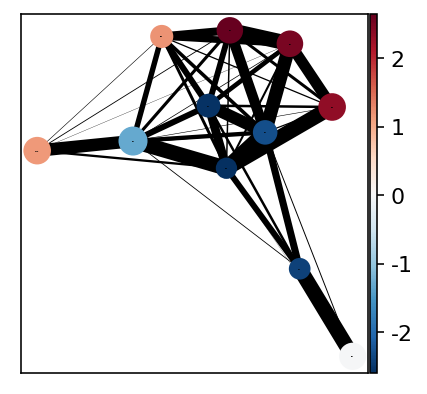

In [197]:
rcParams['figure.figsize'] = 3.3, 3
sc.pl.paga(adata, color=['NES'], fontsize=0)

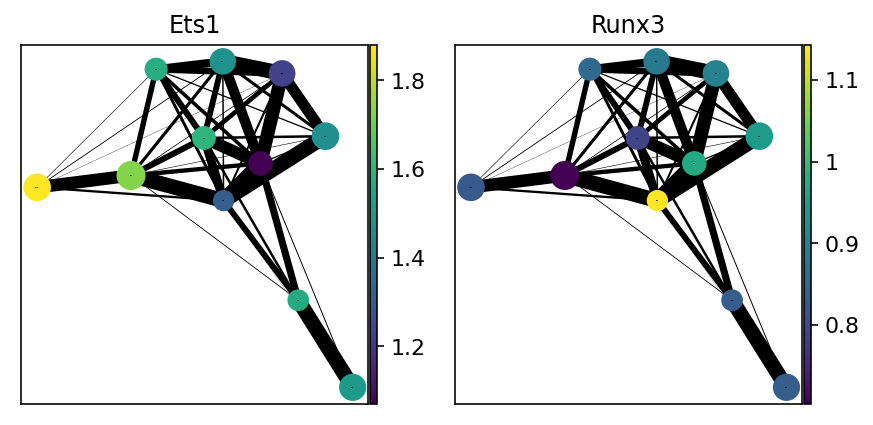

In [205]:
sc.pl.paga(adata, color=['Ets1', 'Runx3'], cmap='viridis', fontsize=0, save="Ets1-Runx3.png")

In [299]:
# Calculate radius of louvain cluster circles
radius_series = np.sqrt(adata.obs.groupby('louvain').count()['cell_type']) 
radius_series_p0_15 = radius_series / radius_series['P0'] * 0.15
radius_series_p0_15

louvain
P9     0.172508
P3     0.154747
P10    0.154425
P0     0.150000
P5     0.142758
P6     0.141793
P2     0.119971
P7     0.112236
P8     0.105121
P1     0.091277
P4     0.087936
Name: cell_type, dtype: float64